In [51]:
import cv2
import numpy as np
import os
from skimage import morphology
from skimage.filters import threshold_minimum
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_fill_holes
from cellpose import models
from skimage.color import label2rgb
import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
import skfuzzy as fuzz

In [52]:
def create_output_dir(dir_name="output_images_bayesian_blue_2"):
    """
    Create an output directory if it doesn't exist yet.

    Parameters
    ----------
    dir_name : str
        Name of the directory to be created.

    Returns
    -------
    str
        The name (path) of the created or existing directory.
    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name


def save_image(image, filename, output_dir):
    """
    Save an image as a PNG file in the specified directory.

    Parameters
    ----------
    image : np.ndarray
        The image array (either grayscale or color).
    filename : str
        The name of the file to be saved (e.g., 'result.png').
    output_dir : str
        Directory path where the image should be saved.

    Returns
    -------
    None
    """
    filepath = os.path.join(output_dir, filename)
    # If the image is color (3 channels), convert from RGB to BGR before saving.
    if len(image.shape) == 3 and image.shape[2] == 3:
        cv2.imwrite(filepath, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    else:
        # For grayscale or mask images, save directly
        cv2.imwrite(filepath, image)


def reinhard_color_normalization(source, target_means, target_stds):
    """
    Perform color normalization using Reinhard's method.

    Parameters
    ----------
    source : np.ndarray
        The source image in BGR format.
    target_means : np.ndarray
        The target mean values (LAB) for normalization (3-element array).
    target_stds : np.ndarray
        The target standard deviations (LAB) for normalization (3-element array).

    Returns
    -------
    np.ndarray
        The color-normalized image in BGR format.
    """
    # Convert to LAB color space
    source_lab = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype(float)

    # Calculate the means and stds of the source image in LAB
    source_means = np.mean(source_lab, axis=(0, 1))
    source_stds = np.std(source_lab, axis=(0, 1))

    # Perform Reinhard normalization
    normalized_lab = source_lab.copy()
    for i in range(3):
        normalized_lab[:, :, i] = (
            (normalized_lab[:, :, i] - source_means[i])
            * (target_stds[i] / source_stds[i])
        ) + target_means[i]

    # Clip the result to valid range and convert back to BGR
    normalized_lab = np.clip(normalized_lab, 0, 255)
    return cv2.cvtColor(normalized_lab.astype(np.uint8), cv2.COLOR_LAB2BGR)


def display_image(title, image, cmap=None):
    """
    Display an image using Matplotlib.

    Parameters
    ----------
    title : str
        The title of the display window (plot).
    image : np.ndarray
        The image array.
    cmap : str or None
        The colormap for grayscale images. If None, the default colormap is used for RGB images.

    Returns
    -------
    None
    """
    plt.figure()
    plt.title(title)
    if len(image.shape) == 2:
        plt.imshow(image, cmap=cmap)
    else:
        # If the image is color in BGR, convert to RGB for proper display
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def morphological_operations(image, operation, kernel_size=(5, 5), iterations=1):
    """
    Apply basic morphological operations (erosion, dilation, opening, closing) with an elliptical kernel.

    Parameters
    ----------
    image : np.ndarray
        Input binary or grayscale image.
    operation : str
        Type of morphological operation ('erosion', 'dilation', 'opening', 'closing').
    kernel_size : tuple, optional
        Size of the elliptical kernel (default is (5, 5)).
    iterations : int, optional
        Number of iterations to apply the operation (default is 1).

    Returns
    -------
    np.ndarray
        The processed image after the morphological operation.

    Raises
    ------
    ValueError
        If the operation string is not one of the supported operations.
    """
    # Create an elliptical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)

    # Perform the specified morphological operation
    if operation == "erosion":
        result = cv2.erode(image, kernel, iterations=iterations)
    elif operation == "dilation":
        result = cv2.dilate(image, kernel, iterations=iterations)
    elif operation == "opening":
        result = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations)
    elif operation == "closing":
        result = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations)
    else:
        raise ValueError(
            "Invalid operation. Choose from 'erosion', 'dilation', 'opening', or 'closing'."
        )

    return result


# Constants for morphological operations
EROSION = "erosion"
DILATION = "dilation"
OPENING = "opening"
CLOSING = "closing"


def show_anns(anns):
    """
    Display annotations (masks) generated by some segmentation algorithm,
    overlayed on the current Matplotlib axes.

    Parameters
    ----------
    anns : list
        A list of annotation dictionaries, each containing at least:
        - 'segmentation': a 2D boolean mask
        - 'area': numeric value for the area of the mask

    Returns
    -------
    None
    """
    if len(anns) == 0:
        return

    # Sort annotations by area (descending)
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    for ann in sorted_anns:
        m = ann["segmentation"]  # 2D boolean mask
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))


def convert_white_background_to_black(img_color, threshold=250):
    """
    Converts white background to black, assuming that "white" pixels
    have all (R, G, B) values above the specified threshold.

    Parameters
    ----------
    img_color : np.ndarray
        Input color image with a potentially white background.
    threshold : int
        Threshold above which a pixel is considered "white". Default is 250.

    Returns
    -------
    img_out : np.ndarray
        The modified image with black background where the original pixels
        exceeded the threshold in all channels (R, G, B).
    """
    img_out = np.copy(img_color)
    white_mask = (
        (img_out[..., 0] > threshold)
        & (img_out[..., 1] > threshold)
        & (img_out[..., 2] > threshold)
    )
    # Set those pixels to (0, 0, 0), i.e., black
    img_out[white_mask] = [0, 0, 0]
    return img_out

In [53]:
def segment_nuclei_cellpose(
    img_array: np.ndarray,
    diameter: float = 200,
    model_type: str = "cyto3",
    gpu: bool = True,
    flow_threshold: float = 0.70,
    cellprob_threshold: float = 0.0,
    do_clahe: bool = True,
    show_plots: bool = True,
    channels: list = [0, 0],
    save_plots_path: str = None  # <-- new argument
):
    """
    Processes an image and segments cell nuclei using Cellpose.
    Optionally shows and/or saves the segmentation figure.

    Parameters
    ----------
    img_array : np.ndarray
        The input image of type np.uint8 (2D), typically grayscale
        (nuclei) extracted from a color image.
    diameter : float
        Estimated size of nuclei (in pixels). Used by the Cellpose model.
    model_type : str
        Model type for Cellpose ('cyto', 'cyto2', 'cyto3', 'nuclei', etc.).
    gpu : bool
        Whether to use the GPU (True) or CPU (False) for Cellpose.
    flow_threshold : float
        Cellpose flow threshold parameter.
    cellprob_threshold : float
        Cellpose cell probability threshold parameter.
    do_clahe : bool
        If True, applies CLAHE before segmentation.
    show_plots : bool
        If True, displays plots and figures using Matplotlib.
    channels : list
        The channels to pass to Cellpose. [0, 0] = single-channel grayscale.
    save_plots_path : str, optional
        If provided and show_plots=True, saves the segmentation figure to this path.

    Returns
    -------
    masks : np.ndarray
        A label array from the Cellpose segmentation (0=background, 1..N=distinct nuclei).
    flows, styles, diams_returned : additional Cellpose outputs.
    num_nuclei : int
        The number of detected nuclei.
    nuclei_areas : np.ndarray
        An array of nucleus areas (in pixels), one entry per nucleus.
    """
    import matplotlib.pyplot as plt
    from cellpose import models
    from skimage.color import label2rgb

    # Step 1: Prepare the image
    if img_array.dtype != np.uint8:
        img_array = (img_array / img_array.max() * 255).astype(np.uint8)

    # If color, convert to grayscale
    if len(img_array.shape) == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    if do_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_prepared = clahe.apply(img_array)
    else:
        img_prepared = img_array.copy()

    if show_plots:
        plt.figure()
        plt.imshow(img_prepared, cmap="gray")
        plt.title("CLAHE Image" if do_clahe else "Input Image")
        plt.axis("off")
        plt.show()

    # Step 2: Run Cellpose
    model = models.Cellpose(gpu=gpu, model_type=model_type)
    masks, flows, styles, diams_returned = model.eval(
        img_prepared,
        diameter=diameter,
        channels=channels,
        flow_threshold=flow_threshold,
        cellprob_threshold=cellprob_threshold,
    )

    # Step 3: Visualize segmentation
    num_nuclei = np.max(masks)
    unique_labels, counts = np.unique(masks, return_counts=True)
    nuclei_areas = counts[1:]  # skip label 0 (background)

    if show_plots:
        colored_masks = label2rgb(masks, image=img_prepared, bg_label=0)
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_prepared, cmap="gray")
        ax[0].set_title("Prepared Image")
        ax[0].axis("off")
        ax[1].imshow(colored_masks)
        ax[1].set_title("Cellpose Segmentation Masks")
        ax[1].axis("off")
        plt.tight_layout()

        # Optionally save
        if save_plots_path is not None:
            fig.savefig(save_plots_path)
            print(f"[Cellpose] Saved segmentation figure to: {save_plots_path}")

        plt.show()

        if num_nuclei > 0:
            plt.figure()
            plt.hist(nuclei_areas, bins=30)
            plt.xlabel("Nucleus area (pixels)")
            plt.ylabel("Frequency")
            plt.title(f"Nuclei area distribution (count: {num_nuclei})")
            plt.show()

    print(f"[Cellpose] Detected {num_nuclei} nuclei.")

    return masks, flows, styles, diams_returned, num_nuclei, nuclei_areas

In [54]:
def process_and_visualize_he_image_blue_channel_with_morphology(
    image_path,
    save_intermediate=False,
    desired_size=None,            # (width, height) tuple or None
    apply_median_filter=False,    # Whether to apply medianBlur
    median_kernel_size=3,         # Median kernel size
    increase_contrast=False,      # Whether to apply additional global contrast
    alpha=1.2,                    # Gain (contrast)
    beta=15,                      # Bias (brightness)
    adjust_blue_after_norm=False, # Whether to additionally adjust the blue channel after normalization
    blue_factor=1.0,              # Multiplier for the blue channel (<1 darkens, >1 brightens)
    blue_offset=0,                # Offset (positive brightens, negative darkens)
    morph_kernel_size=3           # Kernel size for morphological operations
):
    """
    Process an H&E-stained image focusing on the blue channel, applying 
    morphological operations before thresholding. This pipeline includes:

     1. Loading the image.
     2. (Optional) Resizing.
     3. (Optional) Median filter.
     4. (Optional) Additional contrast with linear transform (alpha, beta).
     5. Color normalization using Reinhard's method.
     6. (Optional) Adjusting/darkening the blue channel after normalization.
     7. Extraction of the blue channel.
     8. CLAHE for contrast enhancement.
     9. Selective blue color masking.
     10. Combining the mask with the enhanced blue channel.
     11. Morphological operations to fill holes and remove noise.
     12. Bayesian thresholding.
     13. Creation of a segmentation mask.
     14. Post-processing (removing small objects and holes).
     15. Overlaying the mask on the (possibly resized) image, converting 
         background to white.

    Parameters
    ----------
    image_path : str
        Path to the image file (e.g., .png or .jpg).
    save_intermediate : bool
        Whether to save and display intermediate steps.
    desired_size : tuple or None
        If not None (e.g., (512, 512)), the image is resized to this size.
    apply_median_filter : bool
        Whether to apply medianBlur before color normalization.
    median_kernel_size : int
        Kernel size for the median filter.
    increase_contrast : bool
        Whether to apply linear contrast/brightness adjustment (alpha, beta).
    alpha : float
        Contrast coefficient.
    beta : float
        Brightness coefficient.
    adjust_blue_after_norm : bool
        Whether to manipulate the blue channel after normalization.
    blue_factor : float
        Multiplier for the blue channel (<1 darkens, >1 brightens).
    blue_offset : int
        Offset (positive brightens, negative darkens).
    morph_kernel_size : int
        Kernel size for morphological operations (e.g., 3, 5, 7, etc.).

    Returns
    -------
    nuclei_on_white : np.ndarray
        Image with segmented nuclei overlaid on a white background.
    """
    output_dir = create_output_dir()

    # 1. Load the original image from disk
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load image: {image_path}")

    if save_intermediate:
        save_image(image, "1_original.png", output_dir)
        display_image("Original Image", image)

    # 2. (Optional) Resizing
    if desired_size is not None:
        image = cv2.resize(image, desired_size, interpolation=cv2.INTER_AREA)
        if save_intermediate:
            save_image(image, "1a_resized.png", output_dir)
            display_image("Resized Image", image)

    # 3. (Optional) Median Filtering before color normalization
    if apply_median_filter:
        image = cv2.medianBlur(image, median_kernel_size)
        if save_intermediate:
            save_image(image, "1b_median_filtered.png", output_dir)
            display_image("Median Filtered Image", image)

    # 4. (Optional) Additional Contrast (linear transform: out = alpha * image + beta)
    if increase_contrast:
        # convertScaleAbs applies saturating cast to uint8.
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        if save_intermediate:
            save_image(image, "1c_contrast_enhanced.png", output_dir)
            display_image("Contrast Enhanced Image", image)

    # 5. Reinhard color normalization
    target_means = np.array([128, 128, 128])
    target_stds = np.array([20, 20, 20])
    normalized_image = reinhard_color_normalization(image, target_means, target_stds)
    if save_intermediate:
        save_image(normalized_image, "2_normalized.png", output_dir)
        display_image("Normalized Image", normalized_image)

    # 6. (Optional) Adjust the blue channel after normalization
    #    before extracting it. This can help if small nuclei 
    #    are too bright/dim.
    if adjust_blue_after_norm:
        # Extract the blue channel and treat it as float for manipulation
        blue_float = normalized_image[:, :, 0].astype(np.float32)
        # Apply multiplier
        blue_float *= blue_factor
        # Apply offset
        blue_float += blue_offset
        # Clip to [0, 255]
        blue_float = np.clip(blue_float, 0, 255)
        # Insert back into the image (as uint8)
        normalized_image[:, :, 0] = blue_float.astype(np.uint8)
        if save_intermediate:
            tmp_show = normalized_image[:, :, 0]
            save_image(tmp_show, "2a_adjusted_blue_channel.png", output_dir)
            display_image("Adjusted Blue Channel", tmp_show, cmap="gray")

    # 7. Extract the (potentially adjusted) blue channel
    blue_channel = normalized_image[:, :, 0]
    if save_intermediate:
        save_image(blue_channel, "3_blue_channel.png", output_dir)
        display_image("Blue Channel", blue_channel, cmap="gray")

    # 8. Apply CLAHE on the blue channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    blue_channel_eq = clahe.apply(blue_channel)
    if save_intermediate:
        save_image(blue_channel_eq, "4_blue_channel_eq.png", output_dir)
        display_image("CLAHE on Blue Channel", blue_channel_eq, cmap="gray")

    # 9. Create a selective blue color mask in HSV space
    hsv_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([90, 50, 20])   # Adjust as needed
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
    if save_intermediate:
        save_image(blue_mask, "5_blue_mask.png", output_dir)
        display_image("Blue Mask", blue_mask, cmap="gray")

    # 10. Combine (bitwise AND) the blue mask with the enhanced blue channel
    masked_blue_channel = cv2.bitwise_and(blue_channel_eq, blue_channel_eq, mask=blue_mask)
    if save_intermediate:
        save_image(masked_blue_channel, "6_masked_blue_channel.png", output_dir)
        display_image("Masked Blue Channel", masked_blue_channel, cmap="gray")

    # 11. Morphological operations before thresholding
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    morphed_channel = cv2.morphologyEx(masked_blue_channel, cv2.MORPH_CLOSE, kernel, iterations=2)
    morphed_channel = cv2.morphologyEx(morphed_channel, cv2.MORPH_OPEN, kernel, iterations=1)
    if save_intermediate:
        save_image(morphed_channel, "7_morphed_channel.png", output_dir)
        display_image("Morphological Enhancement", morphed_channel, cmap="gray")

    # 12. Bayesian thresholding (threshold_minimum from skimage)
    threshold = threshold_minimum(morphed_channel)
    print(f"Calculated Bayesian threshold: {threshold}")
    offset = 0  # Adjust if needed
    adjusted_threshold = threshold + offset
    print(f"Adjusted threshold: {adjusted_threshold}")

    # 13. Create a segmentation mask
    segmentation_mask = np.where(morphed_channel >= adjusted_threshold, 255, 0).astype(np.uint8)
    if save_intermediate:
        save_image(segmentation_mask, "9_segmentation_mask.png", output_dir)
        display_image("Segmentation Mask", segmentation_mask, cmap="gray")

    # 14. Remove small objects and small holes
    #    Reduced 'min_size' and 'area_threshold' to 50 as an example
    segmentation_mask_bool = segmentation_mask.astype(bool)
    cleaned_seg_mask = morphology.remove_small_objects(segmentation_mask_bool, min_size=50)
    cleaned_seg_mask = morphology.remove_small_holes(cleaned_seg_mask, area_threshold=50)
    cleaned_seg_mask = cleaned_seg_mask.astype(np.uint8) * 255
    if save_intermediate:
        save_image(cleaned_seg_mask, "11_cleaned_channel.png", output_dir)
        display_image("Cleaned Channel", cleaned_seg_mask, cmap="gray")

    # 15. Overlay the mask on the (possibly resized) image
    #     Convert background to white
    mask_3ch = cv2.merge([cleaned_seg_mask, cleaned_seg_mask, cleaned_seg_mask])
    nuclei_segmented = cv2.bitwise_and(image, mask_3ch)
    white_background = 255 * np.ones_like(image, dtype=np.uint8)
    nuclei_on_white = np.where(mask_3ch == 0, white_background, nuclei_segmented)

    if save_intermediate:
        save_image(nuclei_on_white, "10_nuclei_segmented_white_bg.png", output_dir)
        display_image("Segmented Nuclei on White Background", nuclei_on_white)

    return nuclei_on_white


In [55]:
def sam_automatic_segmentation(
    img_array,
    sam_checkpoint,
    model_type="vit_b",
    device="cuda",
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
    show_plots=True,
):
    """
    Performs automatic image segmentation using the Segment Anything Model (SAM).

    Parameters
    ----------
    img_array : np.ndarray
        The input image, either BGR or RGB.
        SAM internally prefers RGB format.
    sam_checkpoint : str
        Path to the .pth SAM checkpoint file.
    model_type : str
        Model type (e.g., 'vit_b', 'vit_h', 'vit_l').
    device : str
        Device to use: 'cuda' or 'cpu'.
    points_per_side : int
        The number of sample points per side for SamAutomaticMaskGenerator.
    pred_iou_thresh : float
        The prediction IoU threshold (confidence) for mask generation.
    stability_score_thresh : float
        The threshold for mask stability.
    crop_n_layers : int
        Number of layers to use when cropping the image into smaller patches.
    crop_n_points_downscale_factor : int
        Factor to downscale the number of sampling points when cropping.
    min_mask_region_area : int
        Minimum region area (in pixels) for a mask to be considered.
    show_plots : bool
        If True, displays images and masks using Matplotlib.

    Returns
    -------
    masks : list
        A list of masks generated by SamAutomaticMaskGenerator.
        Each mask is a dictionary with keys such as 'segmentation', 'area', etc.
    """
    print("PyTorch version:", torch.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    # Load the SAM model from the specified checkpoint
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    # Convert the image to RGB if it appears to be in BGR
    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        # Heuristically assume the image is BGR if it comes from OpenCV
        image_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    else:
        # Assume it's already RGB or grayscale
        image_rgb = img_array

    # Optional display of the original (RGB) image
    if show_plots:
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.title("Input Image (RGB)")
        plt.axis("off")
        plt.show()

    # Configure the automatic mask generator
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        crop_n_layers=crop_n_layers,
        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
        min_mask_region_area=min_mask_region_area,
    )

    # Generate masks
    print("Generating masks, please wait...")
    masks = mask_generator.generate(image_rgb)
    print(f"Generated {len(masks)} masks.")

    # Optionally visualize results
    if show_plots:
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        show_anns(masks)
        plt.axis("off")
        plt.title("SAM Automatic Masks")
        plt.show()

    return masks

In [56]:
def extract_nuclei_only(
    img_color,
    output_dir=None,
    target_means=np.array([128, 128, 128]),
    target_stds=np.array([20, 20, 20]),
    min_size=30,
    save_intermediate=False,
    use_adaptive_thresholding=False  # New parameter
):
    """
    Extracts nuclei from the original image (img_color) and returns them on a black background.

    Parameters
    ----------
    img_color : np.ndarray
        Input color image (BGR), for example read by cv2.imread().
    output_dir : str or None
        Directory to save intermediate results. If None, no files are saved.
    target_means : np.ndarray
        Target mean values (LAB) for Reinhard color normalization (3-element array).
    target_stds : np.ndarray
        Target standard deviations (LAB) for Reinhard color normalization (3-element array).
    min_size : int
        Minimum object size (in pixels). Any object smaller than this will be removed.
    save_intermediate : bool
        If True, intermediate images are saved (and displayed) at each step.
    use_adaptive_thresholding : bool
        If True, uses adaptive thresholding instead of Otsu thresholding.

    Returns
    -------
    nuclei_only : np.ndarray
        The same shape as the input image, containing only the nuclei (unchanged) and
        the rest filled with black (0 pixel values).
    """
    output_dir = create_output_dir()

    # Step 0: Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(img_color, (5, 5), 0)
    if save_intermediate:
        save_image(blurred_image, "1_blurred.png", output_dir)
        display_image("Blurred Image", blurred_image)

    # 1. Perform color normalization (Reinhard). Assumes you have a function:
    #    reinhard_color_normalization(img, target_means, target_stds).
    normalized_image = reinhard_color_normalization(
        blurred_image, target_means, target_stds
    )
    if save_intermediate:
        save_image(normalized_image, "2_normalized.png", output_dir)
        display_image("Normalized Image", normalized_image)

    # 2. Extract the blue channel (OpenCV uses BGR format; index 0 is Blue).
    blue_channel = normalized_image[:, :, 0]
    if save_intermediate:
        save_image(blue_channel, "3_blue_channel.png", output_dir)
        display_image("Blue Channel", blue_channel, cmap="gray")

    # 3. Apply CLAHE (histogram equalization) with a limited clip limit for contrast enhancement.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    blue_channel_eq = clahe.apply(blue_channel.astype(np.uint8))
    if save_intermediate:
        save_image(blue_channel_eq, "4_blue_channel_eq.png", output_dir)
        display_image("CLAHE on Blue Channel", blue_channel_eq, cmap="gray")

    # 4. Thresholding (Otsu or Adaptive)
    if use_adaptive_thresholding:
        # Use adaptive thresholding
        nuclei_mask = cv2.adaptiveThreshold(
            blue_channel_eq,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Gaussian-weighted sum around neighborhood
            cv2.THRESH_BINARY,
            blockSize=11,  # Size of neighborhood (must be odd)
            C=2  # Constant subtracted from the mean
        )
        if save_intermediate:
            save_image(nuclei_mask, "5_adaptive_threshold.png", output_dir)
            display_image("Adaptive Thresholding", nuclei_mask, cmap="gray")
    else:
        # Use Otsu thresholding
        _, nuclei_mask = cv2.threshold(
            blue_channel_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
        if save_intermediate:
            save_image(nuclei_mask, "5_otsu_threshold.png", output_dir)
            display_image("Otsu Thresholding", nuclei_mask, cmap="gray")

    # 5. Perform morphological opening to remove small white specks.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_opened = cv2.morphologyEx(nuclei_mask, cv2.MORPH_OPEN, kernel)
    if save_intermediate:
        save_image(mask_opened, "6_mask_opened.png", output_dir)
        display_image("Mask Opened", mask_opened, cmap="gray")

    # 6. (Optional) Dilate the mask. If a morphological_operations function is available, use that.
    mask_dil = cv2.dilate(mask_opened, kernel, iterations=2)
    if save_intermediate:
        save_image(mask_dil, "7_mask_dil.png", output_dir)
        display_image("Mask Dilated", mask_dil, cmap="gray")

    # 7. Remove small objects using skimage.remove_small_objects.
    mask_bool = mask_dil > 0
    mask_no_small = remove_small_objects(mask_bool, min_size=min_size)
    mask_no_small = mask_no_small.astype(np.uint8) * 255

    # 8. Fill holes using binary_fill_holes.
    mask_filled = binary_fill_holes(mask_no_small > 0).astype(np.uint8) * 255

    # 9. Overlay the mask on the original (normalized) image to extract only nuclei.
    mask_bool = mask_filled > 0
    nuclei_only = np.zeros_like(img_color)
    nuclei_only[mask_bool] = img_color[mask_bool]

    # 10. Optionally display and/or save the final results.
    if save_intermediate:
        save_image(mask_filled, "8_mask_filled.png", output_dir)
        display_image("Mask Final", mask_filled, cmap="gray")

        save_image(nuclei_only, "9_nuclei_only.png", output_dir)
        display_image("Nuclei Only", nuclei_only)

    # Return the final nuclei-only image on a black background.
    return nuclei_only

def extract_nuclei_from_black_background(
    img_color,
    target_means=np.array([128, 128, 128]),
    target_stds=np.array([20, 20, 20]),
    min_size=50,
    clip_limit=2.0,
    percentile_threshold=10,
    save_intermediate=False,
    output_dir="output_images",
    convert_white_bg_to_black=True,
    threshold_for_white=250,
):
    """
    Extracts nuclei from an image with enhanced debugging to ensure proper segmentation.
    """
    # STEP 0: Optional conversion of white background to black
    if convert_white_bg_to_black:
        img_color = convert_white_background_to_black(img_color, threshold_for_white)
        if save_intermediate:
            save_image(img_color, "converted_white_to_black.png", output_dir)
            display_image("Converted White to Black BG", img_color)

    # Step 1: Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(img_color, (5, 5), 0)
    if save_intermediate:
        save_image(blurred_image, "blurred_image.png", output_dir)
        display_image("Blurred Image", blurred_image)

    # Step 2: Reinhard color normalization
    normalized_image = reinhard_color_normalization(
        blurred_image, target_means, target_stds
    )
    if save_intermediate:
        save_image(normalized_image, "normalized_image.png", output_dir)
        display_image("Normalized Image", normalized_image)

    # Step 3: Extract the blue channel
    blue_channel = normalized_image[:, :, 0]
    if save_intermediate:
        save_image(blue_channel, "blue_channel.png", output_dir)
        display_image("Blue Channel", blue_channel, cmap="gray")

    # Step 4: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    blue_channel_eq = clahe.apply(blue_channel)
    if save_intermediate:
        save_image(blue_channel_eq, "blue_channel_eq.png", output_dir)
        display_image("CLAHE on Blue Channel", blue_channel_eq, cmap="gray")

    # Step 5: Determine the threshold based on a percentile
    threshold_value = np.percentile(blue_channel_eq, percentile_threshold)
    print(f"Threshold Value (Percentile {percentile_threshold}): {threshold_value}")

    # Apply binary thresholding
    _, nuclei_mask = cv2.threshold(
        blue_channel_eq, threshold_value, 255, cv2.THRESH_BINARY
    )
    if save_intermediate:
        save_image(nuclei_mask, "nuclei_mask.png", output_dir)
        display_image("Nuclei Mask", nuclei_mask, cmap="gray")

    # Step 6: Morphological opening to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_opened = cv2.morphologyEx(nuclei_mask, cv2.MORPH_OPEN, kernel)
    if save_intermediate:
        save_image(mask_opened, "mask_opened.png", output_dir)
        display_image("Morphologically Opened Mask", mask_opened, cmap="gray")

    # Step 8: Remove small objects
    mask_bool = mask_opened > 0
    mask_no_small = remove_small_objects(mask_bool, min_size=min_size)
    mask_no_small = mask_no_small.astype(np.uint8) * 255
    if save_intermediate:
        save_image(mask_no_small, "mask_no_small.png", output_dir)
        display_image("Mask Without Small Objects", mask_no_small, cmap="gray")

    # Step 7: Dilate the mask
    mask_dil = cv2.dilate(mask_no_small, kernel, iterations=2)
    if save_intermediate:
        save_image(mask_dil, "mask_dil.png", output_dir)
        display_image("Dilated Mask", mask_dil, cmap="gray")

    # Step 9: Fill holes in the mask
    mask_filled = binary_fill_holes(mask_no_small > 0).astype(np.uint8) * 255
    if save_intermediate:
        save_image(mask_filled, "mask_filled.png", output_dir)
        display_image("Filled Mask", mask_filled, cmap="gray")

    # Step 10: Apply the mask to the normalized image
    mask_bool = mask_filled > 0
    nuclei_only = np.zeros_like(img_color)
    nuclei_only[mask_bool] = img_color[mask_bool]

    if save_intermediate:
        save_image(nuclei_only, "nuclei_only.png", output_dir)
        display_image("Extracted Nuclei Only", nuclei_only)

    return nuclei_only, mask_filled



def fuzzy_cmeans_in_rgb_2clusters(
    cell_on_black,
    convert_white_bg_to_black=True,
    threshold_for_white=250,
    save_intermediate=False,
    output_dir="output_images",
    min_size=50
):
    """
    Performs Fuzzy C-means clustering (2 clusters) in the BGR color space,
    with the option to convert a white background to black first. 
    Automatically picks the cluster with the lower sum of BGR values as nuclei.

    Parameters
    ----------
    cell_on_black : np.ndarray
        An image in BGR format where the background is either entirely black (0,0,0)
        or, if convert_white_bg_to_black=True, it may start as white (and will be converted).
    convert_white_bg_to_black : bool
        If True, attempts to convert any white background to black before clustering.
    threshold_for_white : int
        Threshold above which a pixel is considered "white" in all channels.
    save_intermediate : bool
        If True, displays (and potentially saves) intermediate steps.
    output_dir : str
        Directory where intermediate images could be saved (if the save_image function is used).
    min_size : int
        Minimum object size (in pixels) to keep after fuzzy clustering (remove_small_objects).

    Returns
    -------
    final_mask : np.ndarray
        A 2D binary mask (dtype=uint8) indicating nuclei (1) vs. background (0).
    masked_nuclei : np.ndarray
        A color image of the same shape as `cell_on_black`, where the background
        is black and the detected nuclei are shown in their original colors.
    """
     
    # STEP 0: (Optional) Convert a white background to black
     
    if convert_white_bg_to_black:
        cell_on_black = convert_white_background_to_black(cell_on_black, threshold_for_white)
        if save_intermediate:
            display_image("Converted White to Black BG", cell_on_black)
            save_image(cell_on_black, "converted_white_to_black.png", output_dir)

     
    # STEP 1: Show or save the input image (now guaranteed to be black BG)
     
    if save_intermediate:
        display_image("Original (cell_on_black)", cell_on_black)
        save_image(cell_on_black, "original_cell_on_black.png", output_dir)

    # Apply a median blur to reduce small noise
    blurred_img = cv2.medianBlur(cell_on_black, 3)

    # STEP 2: Create a mask for black background vs. cell region
     
    black_mask = np.all(blurred_img == [0, 0, 0], axis=-1)  # shape: (H, W)
    cell_mask = ~black_mask                                # True for pixels belonging to cells

    h, w, _ = cell_on_black.shape

     
    # STEP 3: Extract the pixels corresponding to the cell (B, G, R)
     
    cell_pixels_bgr = blurred_img[cell_mask]  # shape: (N, 3)
    if cell_pixels_bgr.size == 0:
        print("No cell pixels found — possibly an empty or fully black image.")
        return None, None

    # Prepare data for fuzzy clustering: we want shape (3, N)
    data = cell_pixels_bgr.T.astype(np.float32)

     
    # STEP 4: Fuzzy C-means clustering with 2 clusters
     
    c = 2
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data, 
        c=c, 
        m=2.0,       # fuzziness parameter
        error=0.005, # convergence criterion
        maxiter=1000,
        init=None
    )

    print("Cluster centroids (BGR space):")
    for i in range(c):
        print(f"  Cluster {i}: {cntr[i]}")

     
    # STEP 5: Automatically pick the cluster with the lower sum of BGR values
    #         as the "nucleus" cluster
     
    cluster_sums = [np.sum(cntr[i]) for i in range(c)]
    nucleus_cluster_idx = int(np.argmin(cluster_sums))
    print(f"Choosing cluster {nucleus_cluster_idx} as the nucleus cluster (lowest sum of BGR).")

    # Assign each pixel to whichever cluster has the highest membership
    cluster_membership = np.argmax(u, axis=0)  # shape: (N,)

    # Build a 2D mask for the final segmentation
    fuzzy_mask_2d = np.zeros((h, w), dtype=np.uint8)
    fuzzy_mask_2d[cell_mask] = (cluster_membership == nucleus_cluster_idx).astype(np.uint8)

    if save_intermediate:
        display_image("Fuzzy Mask 2D (initial)", fuzzy_mask_2d * 255, cmap="gray")
        save_image(fuzzy_mask_2d * 255, "fuzzy_mask_2d_initial.png", output_dir)

     
    # STEP 6: Morphological cleaning (fill holes, remove small objects, etc.)
     
    # Fill holes
    mask_filled = binary_fill_holes(fuzzy_mask_2d).astype(np.uint8)

    # Remove small objects
    mask_cleaned = remove_small_objects(mask_filled.astype(bool), min_size=min_size).astype(np.uint8)

    # Close operation to smooth edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_mask = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    if save_intermediate:
        display_image("Final Mask (morphological close)", final_mask * 255, cmap="gray")
        save_image(final_mask * 255, "final_mask_morph_close.png", output_dir)

    # (Optional) refine edges with a dilation + another closing
    mask_dilated = cv2.dilate(final_mask, kernel, iterations=1)
    final_mask = cv2.morphologyEx(mask_dilated, cv2.MORPH_CLOSE, kernel)

     
    # STEP 7: Overlay the final mask on the original image (with black BG)
     
    masked_nuclei = np.zeros_like(cell_on_black)
    masked_nuclei[final_mask == 1] = cell_on_black[final_mask == 1]

    if save_intermediate:
        display_image("Segmented Nuclei (final)", masked_nuclei)
        save_image(masked_nuclei, "segmented_nuclei_final.png", output_dir)

    return final_mask, masked_nuclei

In [ ]:
import numpy as np
import cv2
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
from joblib import Parallel, delayed

import numpy as np
import cv2
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis

def extract_texture_features(
    image,
    mask,
    min_region_size=50,
    downsample_factor=1.0,
    compute_region_features=True,
    compute_global_glcm=True
):
    """
    Extracts texture features from an image and mask with optional steps:
      - (A) Region-based features (mean, std, skew, kurtosis, histogram-based entropy).
      - (B) A single global GLCM (co-occurrence matrix) for the masked region.

    Parameters
    ----------
    image : np.ndarray
        Input image (BGR or grayscale). If color, it will be converted to grayscale.
    mask : np.ndarray
        Binary mask (non-zero = region). Must match 'image' shape or be resized.
    min_region_size : int, optional
        Minimal number of pixels for a region to be considered. Default=50.
    downsample_factor : float, optional
        If <1.0, resizes the image & mask to speed up computation
        (e.g., 0.5 => half width/height => 1/4 pixel count).
    compute_region_features : bool, optional
        If True, compute per-region features. If False, skip labeling to save time.
    compute_global_glcm : bool, optional
        If True, compute a single global GLCM for the masked region. If False, skip.

    Returns
    -------
    features : dict
        A dictionary that can contain:
         - If compute_region_features=True:
             "mean_intensity_i", "std_intensity_i", "skew_intensity_i",
             "kurtosis_intensity_i", "entropy_hist_i" for each region i.
         - If compute_global_glcm=True:
             "GLCM_contrast", "GLCM_homogeneity", "GLCM_energy", "GLCM_correlation".
    """

    # 1. Convert to grayscale if needed
    if image.ndim == 3:
        gray_img = rgb2gray(image)
    else:
        # already grayscale
        gray_img = image.astype(float)

    # 2. Scale to [0..255] (uint8)
    gray_img = (gray_img * 255).astype(np.uint8)

    # 2a. Downsampling if requested
    if downsample_factor < 1.0:
        new_w = int(gray_img.shape[1] * downsample_factor)
        new_h = int(gray_img.shape[0] * downsample_factor)
        gray_img = cv2.resize(gray_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        mask = mask.astype(np.uint8)
        mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # 3. Ensure image/mask shape match
    if mask.shape != gray_img.shape:
        mask = mask.astype(np.uint8)
        mask = cv2.resize(
            mask,
            (gray_img.shape[1], gray_img.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )
    mask = (mask > 0)

    # Prepare the results container
    features = {}

    # (A) Optional: Region-based features
    if compute_region_features:
        # 4. Label connected components
        labeled_mask = label(mask)
        regions = regionprops(labeled_mask, intensity_image=gray_img)

        for region_id, region in enumerate(regions):
            if region.area < min_region_size:
                continue

            # Extract region intensity
            region_intensity = region.intensity_image[region.image]

            # Intensity stats
            features[f"mean_intensity_{region_id}"]  = np.mean(region_intensity)
            features[f"std_intensity_{region_id}"]   = np.std(region_intensity)
            features[f"skew_intensity_{region_id}"]  = skew(region_intensity, axis=None)
            features[f"kurtosis_intensity_{region_id}"] = kurtosis(region_intensity, axis=None)

            # Histogram-based entropy
            hist, _ = np.histogram(region_intensity, bins=16, range=(0, 255))
            p = hist / (np.sum(hist) + 1e-10)
            entropy_val = -np.sum(p * np.log2(p + 1e-10))
            features[f"entropy_hist_{region_id}"] = entropy_val

    # (B) Optional: Global GLCM for the entire masked region
    if compute_global_glcm:
        # zero out background
        gray_masked = gray_img.copy()
        gray_masked[~mask] = 0

        glcm = graycomatrix(
            gray_masked,
            distances=[1],
            angles=[0],
            levels=256,
            symmetric=True,
            normed=True
        )
        features["GLCM_contrast"]     = graycoprops(glcm, 'contrast')[0, 0]
        features["GLCM_homogeneity"]  = graycoprops(glcm, 'homogeneity')[0, 0]
        features["GLCM_energy"]       = graycoprops(glcm, 'energy')[0, 0]
        features["GLCM_correlation"]  = graycoprops(glcm, 'correlation')[0, 0]

    return features


In [ ]:
import pandas as pd
# Process the provided image
image_path = r"D:\studia\magisterka\FNA\G1\400x\15b.bmp"
try:
    nuclei_on_white = process_and_visualize_he_image_blue_channel_with_morphology(
        image_path=image_path,
        save_intermediate=False,
        desired_size=None,
        apply_median_filter=True,
        median_kernel_size=3,
        increase_contrast=False,
        alpha=1.3,
        beta=15,
        adjust_blue_after_norm=True,
        blue_factor=1.25,      
        blue_offset=+15,       
        morph_kernel_size=3    
    )
    print("Processing completed successfully. Check the output directory for results.")
except Exception as e:
    print(f"An error occurred: {str(e)}")
only_nucleis_1 = extract_nuclei_only(nuclei_on_white)

nuclei_only, mask_filled = extract_nuclei_from_black_background(
    nuclei_on_white
)
final_mask, masked_nuclei = fuzzy_cmeans_in_rgb_2clusters(
    nuclei_on_white
)

# nuclei_only = extract_nuclei_only(
#     img_color=nuclei_on_white,
#     output_dir="output",
#     save_intermediate=True,
#     use_adaptive_thresholding=True  # Enable adaptive thresholding
# )
# Create a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Nuclei on white background
axes[0, 0].imshow(cv2.cvtColor(nuclei_on_white, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
axes[0, 0].set_title("Nuclei on White")
axes[0, 0].axis("off")

# Plot 2: Extracted nuclei only (method 1)
axes[0, 1].imshow(cv2.cvtColor(only_nucleis_1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
axes[0, 1].set_title("Only Nuclei (Method 1)")
axes[0, 1].axis("off")

# Plot 3: Extracted nuclei only (method 2)
axes[1, 0].imshow(cv2.cvtColor(nuclei_only, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
axes[1, 0].set_title("Only Nuclei (Method 2)")
axes[1, 0].axis("off")

# Plot 4: Final segmented nuclei (fuzzy c-means)
axes[1, 1].imshow(cv2.cvtColor(masked_nuclei, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
axes[1, 1].set_title("Segmented Nuclei (Fuzzy C-means)")
axes[1, 1].axis("off")

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

masks, flows, styles, diams_returned, num_nuclei, nuclei_areas = (
    segment_nuclei_cellpose(masked_nuclei, show_plots=True)
)


In [ ]:
# Extract texture features for individual nuclei (from Cellpose masks)
texture_features = []
labeled_mask = label(masks)

for region_id in range(1, np.max(labeled_mask) + 1):
    region_mask = labeled_mask == region_id
    features = extract_texture_features(only_nucleis_1, region_mask, downsample_factor=0.25)
    texture_features.append(features)

# Create a DataFrame for individual nuclei texture features
individual_features_df = pd.DataFrame(texture_features)

# Extract texture features for the entire image
full_image_mask = np.ones(only_nucleis_1.shape[:2], dtype=bool)
full_image_features = extract_texture_features(
    only_nucleis_1, 
    full_image_mask, 
    downsample_factor=0.5
)

# Compute the mean feature vector for the image
aggregated_features = individual_features_df.mean(axis=0).to_dict()

# Combine all features into a final DataFrame
final_feature_df = pd.DataFrame({
    "Full_Image_Features": pd.Series(full_image_features),
    "Aggregated_Nuclei_Features": pd.Series(aggregated_features)
}).T

# Save results to CSV for classification or further analysis
output_path = "final_features.csv"
final_feature_df.to_csv(output_path, index=False)

print(f"Feature extraction completed. Results saved to: {output_path}")


Feature extraction completed. Results saved to: final_features.csv


In [10]:
import os
import glob
import shutil
import logging

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.segmentation import find_boundaries

# Import or define all custom functions used:
# - process_and_visualize_he_image_blue_channel_with_morphology
# - extract_nuclei_only
# - extract_nuclei_from_black_background
# - fuzzy_cmeans_in_rgb_2clusters
# - segment_nuclei_cellpose
# - extract_texture_features


def process_single_image(image_path, output_dir):
    """
    Processes a single image: segmentation, feature extraction, and saving results.

    Parameters
    ----------
    image_path : str
        Path to the image file to process.
    output_dir : str
        Directory where all results will be saved.
    """
    try:
        logging.info(f"Starting to process {image_path}")

        # 1. Load and process the image
        nuclei_on_white = process_and_visualize_he_image_blue_channel_with_morphology(
            image_path=image_path,
            save_intermediate=False,
            desired_size=None,
            apply_median_filter=True,
            median_kernel_size=3,
            increase_contrast=False,
            alpha=1.3,
            beta=15,
            adjust_blue_after_norm=True,
            blue_factor=1.0,
            blue_offset=0,
            morph_kernel_size=3
        )
        logging.debug("Finished process_and_visualize_he_image_blue_channel_with_morphology")
        display_image("nuclei_on_white", nuclei_on_white)

        # 2. Different methods for nuclei extraction
        final_mask, masked_nuclei = fuzzy_cmeans_in_rgb_2clusters(nuclei_on_white)
        only_nucleis_1 = extract_nuclei_only(nuclei_on_white)
        display_image("only_nucleis_1", only_nucleis_1)
        logging.debug("Extracted nuclei (method 1)")
        display_image("masked_nuclei", masked_nuclei)

        # 3. Nuclei segmentation using Cellpose
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        seg_figure_path = os.path.join(output_dir, f"{image_name}_cellpose_masks.png")

        masks, flows, styles, diams_returned, num_nuclei, nuclei_areas = segment_nuclei_cellpose(
            only_nucleis_1,
            show_plots=True,
            diameter=60,
            save_plots_path=seg_figure_path
        )
        logging.debug(f"Cellpose segmentation complete. Number of nuclei found: {num_nuclei}")

        # Draw white outlines on top of masked nuclei
        boundaries = find_boundaries(masks, connectivity=1, mode='outer')

        overlay_img = masked_nuclei.copy()
        overlay_img[boundaries] = [255, 255, 255]

        # Save the overlay
        segmented_name = f"{image_name}_segmented.png"
        cv2.imwrite(
            os.path.join(output_dir, segmented_name),
            overlay_img
        )
        logging.debug(f"Unique segmentation overlay saved as {segmented_name}")

        # 4. Extract texture features
        texture_features = []
        labeled_mask = label(masks)

        for region_id in range(1, np.max(labeled_mask) + 1):
            region_mask = labeled_mask == region_id
            features = extract_texture_features(masked_nuclei, region_mask, downsample_factor=0.25)
            texture_features.append(features)

        individual_features_df = pd.DataFrame(texture_features)
        full_image_mask = np.ones(masked_nuclei.shape[:2], dtype=bool)
        full_image_features = extract_texture_features(
            masked_nuclei,
            full_image_mask,
            downsample_factor=0.25
        )
        aggregated_features = individual_features_df.mean(axis=0).to_dict()

        # Create a consolidated DataFrame
        final_feature_df = pd.DataFrame({
            "Full_Image_Features": pd.Series(full_image_features),
            "Aggregated_Nuclei_Features": pd.Series(aggregated_features)
        }).T

        # Calculate the average of the two feature sets
        mean_features = {
            key: (full_image_features[key] + aggregated_features[key]) / 2
            for key in full_image_features.keys()
        }

        # Add the mean feature vector to the DataFrame
        final_feature_df.loc["Mean_Features"] = pd.Series(mean_features)

        # 5. Save results
        csv_name = f"{image_name}_features.csv"
        original_image_name = f"{image_name}_original.png"
        masked_nuclei_name = f"{image_name}_segmented.png"

        csv_path = os.path.join(output_dir, csv_name)
        final_feature_df.to_csv(csv_path, index=False)
        logging.info(f"Features saved to {csv_path}")

        # Save the original processed image
        cv2.imwrite(
            os.path.join(output_dir, original_image_name),
            cv2.cvtColor(nuclei_on_white, cv2.COLOR_BGR2RGB)
        )
        logging.debug(f"Original processed image saved as {original_image_name}")

        # Save the final segmented image
        cv2.imwrite(
            os.path.join(output_dir, masked_nuclei_name),
            cv2.cvtColor(masked_nuclei, cv2.COLOR_BGR2RGB)
        )
        logging.debug(f"Segmented image saved as {masked_nuclei_name}")

        logging.info(f"[OK] Finished processing {image_path}, results in {output_dir}")

    except Exception as e:
        logging.error(f"[ERROR] Error while processing {image_path}: {e}", exc_info=True)
        print(f"[ERROR] Error while processing {image_path}: {e}")


def main_pipeline():
    """
    Main pipeline for processing images in groups and magnifications.

    This function logs results and saves processed images and features for
    each image in the specified directory structure.
    """
    base_dir = r"D:\studia\magisterka\FNA"
    logs_folder = os.path.join(base_dir, "logs")
    os.makedirs(logs_folder, exist_ok=True)

    log_file = os.path.join(logs_folder, "pipeline.log")
    logging.basicConfig(
        filename=log_file,
        filemode='a',
        level=logging.DEBUG,
        format="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )

    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s", datefmt="%H:%M:%S")
    console_handler.setFormatter(formatter)
    logging.getLogger().addHandler(console_handler)

    logging.info("=== Starting main_pipeline ===")

    groups = ["G2"]
    magnifications = ["100x"]

    for group in groups:
        for mag in magnifications:
            image_dir = os.path.join(base_dir, group, mag)
            if not os.path.isdir(image_dir):
                logging.warning(f"Folder not found: {image_dir}, skipping...")
                continue

            output_dir = os.path.join(image_dir, "post-segment")
            os.makedirs(output_dir, exist_ok=True)

            image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
            if not image_paths:
                logging.info(f"No .jpg files in: {image_dir}, skipping...")
                continue

            for img_path in image_paths:
                process_single_image(img_path, output_dir)

    logging.info("=== Finished main_pipeline ===")


# if __name__ == "__main__":
#     main_pipeline()


In [50]:
import numpy as np
import cv2
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
import mahotas

def extract_texture_features(
    image,
    mask,
    mode='all',                # Determines the output format: 'all' for lists, 'single' for scalars
    min_region_size=0,
    downsample_factor=1.0,
    compute_region_features=True,
    compute_global_glcm=True,
    compute_moments_hu=True,
    compute_zernike=True
):
    """
    Extracts texture, intensity, and shape features from the given image and mask.

    Parameters
    ----------
    image : np.ndarray
        The input image (grayscale or RGB) from which features are extracted.
    mask : np.ndarray
        The binary mask indicating regions of interest in the image.
    mode : str, optional
        Determines the output format:
        - 'all': Iterates over all regions and returns features as lists (one value per region).
        - 'single': Assumes the mask contains a single region (or considers the first region only) and
          returns features as scalars.
    min_region_size : int, optional
        Minimum region size to consider for feature extraction.
    downsample_factor : float, optional
        Factor by which to downsample the image and mask.
    compute_region_features : bool, optional
        Whether to compute region-based features.
    compute_global_glcm : bool, optional
        Whether to compute global GLCM (Gray Level Co-occurrence Matrix) features.
    compute_moments_hu : bool, optional
        Whether to compute Hu moments for each region.
    compute_zernike : bool, optional
        Whether to compute Zernike moments for each region.

    Returns
    -------
    features : dict
        A dictionary containing the extracted features. The structure depends on the mode parameter.
        - For mode='all': Keys are feature names, values are lists (one entry per region).
        - For mode='single': Keys are feature names, values are scalars.
        - Global GLCM features are always single values (floats).
    """
    # 1. Convert to grayscale if RGB
    if image.ndim == 3:
        gray_img = rgb2gray(image)
    else:
        gray_img = image.astype(float)

    # 2. Scale to [0..255]
    gray_img = (gray_img * 255).astype(np.uint8)

    # 2a. Downsampling if required
    if downsample_factor < 1.0:
        new_w = int(gray_img.shape[1] * downsample_factor)
        new_h = int(gray_img.shape[0] * downsample_factor)
        gray_img = cv2.resize(gray_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Resize the mask using nearest neighbor interpolation
        mask = mask.astype(np.uint8)
        mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # 3. Match the size of the mask to the image
    if mask.shape != gray_img.shape:
        mask = mask.astype(np.uint8)
        mask = cv2.resize(
            mask,
            (gray_img.shape[1], gray_img.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )

    # Convert the mask to boolean
    mask = (mask > 0)

    # Prepare the results dictionary
    features = {}

    # ============================================
    # (A) Region-based features
    # ============================================
    if compute_region_features:
        labeled_mask = label(mask)
        regions = regionprops(labeled_mask, intensity_image=gray_img)

        if mode == 'all':
            # Initialize lists for all region-based features
            features.update({
                "mean_intensity": [],
                "std_intensity": [],
                "skew_intensity": [],
                "kurtosis_intensity": [],
                "entropy_hist": [],
                "bounding_box_width": [],
                "bounding_box_height": [],
                "area": [],
                "perimeter": [],
                "eccentricity": [],
                "solidity": [],
                "extent": [],
                "major_axis_length": [],
                "minor_axis_length": [],
                "circularity": [],
                "zernike": []
            })

            for i in range(1, 8):  # Hu moments (7 values)
                features[f"hu_moment_{i}"] = []

            # Iterate over all regions
            for region in regions:
                if region.area < min_region_size:
                    continue

                region_intensity = region.intensity_image[region.image]
                mean_val = np.mean(region_intensity)
                std_val = np.std(region_intensity)
                skew_val = skew(region_intensity, axis=None)
                kurt_val = kurtosis(region_intensity, axis=None)

                hist, _ = np.histogram(region_intensity, bins=16, range=(0, 255))
                p = hist / (np.sum(hist) + 1e-10)
                entropy_val = -np.sum(p * np.log2(p + 1e-10))

                bbox = region.bbox
                bbox_width = bbox[3] - bbox[1]
                bbox_height = bbox[2] - bbox[0]

                area = region.area
                perimeter = region.perimeter
                eccentricity = region.eccentricity
                solidity = region.solidity
                extent = region.extent
                major_axis_length = region.major_axis_length
                minor_axis_length = region.minor_axis_length

                circularity_val = 4.0 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0.0

                # Append to the feature lists
                features["mean_intensity"].append(mean_val)
                features["std_intensity"].append(std_val)
                features["skew_intensity"].append(skew_val)
                features["kurtosis_intensity"].append(kurt_val)
                features["entropy_hist"].append(entropy_val)
                features["bounding_box_width"].append(bbox_width)
                features["bounding_box_height"].append(bbox_height)
                features["area"].append(area)
                features["perimeter"].append(perimeter)
                features["eccentricity"].append(eccentricity)
                features["solidity"].append(solidity)
                features["extent"].append(extent)
                features["major_axis_length"].append(major_axis_length)
                features["minor_axis_length"].append(minor_axis_length)
                features["circularity"].append(circularity_val)

                if compute_moments_hu:
                    region_mask = (labeled_mask == region.label).astype(np.uint8)
                    try:
                        cv_mom = cv2.moments(region_mask, binaryImage=True)
                        hu_vals = cv2.HuMoments(cv_mom).flatten()
                        for i in range(7):
                            features[f"hu_moment_{i+1}"].append(hu_vals[i])
                    except:
                        for i in range(7):
                            features[f"hu_moment_{i+1}"].append(np.nan)

                if compute_zernike:
                    region_mask = (labeled_mask == region.label).astype(float)
                    try:
                        radius = min(bbox_width, bbox_height) / 2
                        zern = mahotas.features.zernike_moments(region_mask, radius=radius)
                        features["zernike"].append(zern)
                    except:
                        features["zernike"].append(np.nan)

        elif mode == 'single':
            if len(regions) == 0:
                return {}

            region = regions[0]
            if region.area < min_region_size:
                return {}

            region_intensity = region.intensity_image[region.image]
            mean_val = np.mean(region_intensity)
            std_val = np.std(region_intensity)
            skew_val = skew(region_intensity, axis=None)
            kurt_val = kurtosis(region_intensity, axis=None)

            hist, _ = np.histogram(region_intensity, bins=16, range=(0, 255))
            p = hist / (np.sum(hist) + 1e-10)
            entropy_val = -np.sum(p * np.log2(p + 1e-10))

            bbox = region.bbox
            bbox_width = bbox[3] - bbox[1]
            bbox_height = bbox[2] - bbox[0]

            area = region.area
            perimeter = region.perimeter
            eccentricity = region.eccentricity
            solidity = region.solidity
            extent = region.extent
            major_axis_length = region.major_axis_length
            minor_axis_length = region.minor_axis_length

            circularity_val = 4.0 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0.0

            features.update({
                "mean_intensity": mean_val,
                "std_intensity": std_val,
                "skew_intensity": skew_val,
                "kurtosis_intensity": kurt_val,
                "entropy_hist": entropy_val,
                "bounding_box_width": bbox_width,
                "bounding_box_height": bbox_height,
                "area": area,
                "perimeter": perimeter,
                "eccentricity": eccentricity,
                "solidity": solidity,
                "extent": extent,
                "major_axis_length": major_axis_length,
                "minor_axis_length": minor_axis_length,
                "circularity": circularity_val
            })

            if compute_moments_hu:
                region_mask = (labeled_mask == region.label).astype(np.uint8)
                try:
                    cv_mom = cv2.moments(region_mask, binaryImage=True)
                    hu_vals = cv2.HuMoments(cv_mom).flatten()
                    for i in range(7):
                        features[f"hu_moment_{i+1}"] = hu_vals[i]
                except:
                    for i in range(7):
                        features[f"hu_moment_{i+1}"] = np.nan

            if compute_zernike:
                region_mask = (labeled_mask == region.label).astype(float)
                try:
                    radius = min(bbox_width, bbox_height) / 2
                    zern = mahotas.features.zernike_moments(region_mask, radius=radius)
                    for i, val in enumerate(zern):
                        features[f"zernike_{i}"] = val
                except:
                    features["zernike_0"] = np.nan

    # ============================================
    # (B) Global GLCM (single values for the entire mask)
    # ============================================
    if compute_global_glcm:
        try:
            gray_masked = gray_img.copy()
            gray_masked[~mask] = 0

            glcm = graycomatrix(
                gray_masked,
                distances=[1, 2, 3],
                angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                levels=256,
                symmetric=True,
                normed=True
            )
            features["GLCM_contrast"] = float(np.mean(graycoprops(glcm, 'contrast')))
            features["GLCM_homogeneity"] = float(np.mean(graycoprops(glcm, 'homogeneity')))
            features["GLCM_energy"] = float(np.mean(graycoprops(glcm, 'energy')))
            features["GLCM_correlation"] = float(np.mean(graycoprops(glcm, 'correlation')))
        except:
            features.update({
                "GLCM_contrast": np.nan,
                "GLCM_homogeneity": np.nan,
                "GLCM_energy": np.nan,
                "GLCM_correlation": np.nan
            })

    return features


In [78]:
import numpy as np
import os
import cv2
import pandas as pd
from skimage.measure import label
from scipy.stats import variation  # CV = coefficient of variation

def process_single_image(image_path, output_dir):
    """
    Processes a single image, performs segmentation, extracts features,
    computes diversity metrics, and saves the results in a dedicated folder.

    Parameters
    ----------
    image_path : str
        Path to the image to process.
    output_dir : str
        Path to the directory where the results will be saved.

    """
    try:
        # Create a dedicated folder for results
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        image_output_dir = os.path.join(output_dir, image_name)
        os.makedirs(image_output_dir, exist_ok=True)

        # 1. Load and process the image (e.g., with blue channel and morphology)
        nuclei_on_white = process_and_visualize_he_image_blue_channel_with_morphology(
            image_path=image_path,
            save_intermediate=False,
            desired_size=None,
            apply_median_filter=True,
            median_kernel_size=3,
            increase_contrast=False,
            alpha=1.3,
            beta=15,
            adjust_blue_after_norm=True,
            blue_factor=1,
            blue_offset=0,
            morph_kernel_size=3
        )
        only_nucleis_1 = extract_nuclei_only(nuclei_on_white)
        display_image('only', only_nucleis_1)

        # Save the pre-segmented image
        pre_segmentation_image_path = os.path.join(image_output_dir, f"{image_name}_pre_segmented.png")
        cv2.imwrite(pre_segmentation_image_path, cv2.cvtColor(only_nucleis_1, cv2.COLOR_BGR2RGB))

        # 2. Segmentation with Cellpose
        seg_figure_path = os.path.join(image_output_dir, f"{image_name}_cellpose_masks.png")
        masks, flows, styles, diams_returned, num_nuclei, nuclei_areas = segment_nuclei_cellpose(
            only_nucleis_1,
            show_plots=True,
            diameter=80,
            save_plots_path=seg_figure_path
        )

        # Adjust mask dimensions to match the original image if necessary
        if masks.shape[:2] != only_nucleis_1.shape[:2]:
            masks = cv2.resize(
                masks,
                (only_nucleis_1.shape[1], only_nucleis_1.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )

        # 3. Extract features for each nucleus ("single" mode)
        labeled_mask = label(masks)
        texture_features = []

        for region_id in range(1, np.max(labeled_mask) + 1):
            region_mask = (labeled_mask == region_id)
            features = extract_texture_features(
                image=only_nucleis_1,
                mask=region_mask,
                mode='single',
                downsample_factor=0.5
            )
            features["region_id"] = region_id
            texture_features.append(features)

        individual_features_df = pd.DataFrame(texture_features)

        # 4. Diversity metrics (CV, std, min, max)
        diversity_features = {}
        numeric_cols = individual_features_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            col_series = individual_features_df[col].dropna()
            diversity_features[f"cv_{col}"] = variation(col_series) if len(col_series) > 1 else np.nan
            diversity_features[f"std_{col}"] = col_series.std()
            diversity_features[f"min_{col}"] = col_series.min()
            diversity_features[f"max_{col}"] = col_series.max()

        # 5. Hierarchical analysis of nuclei sizes (small, medium, large)
        if "area" not in numeric_cols:
            raise ValueError("'area' column is missing or not numeric in the extracted features.")

        small_nuclei = individual_features_df[individual_features_df["area"] <= individual_features_df["area"].quantile(0.33)]
        medium_nuclei = individual_features_df[
            (individual_features_df["area"] > individual_features_df["area"].quantile(0.33)) &
            (individual_features_df["area"] <= individual_features_df["area"].quantile(0.66))
        ]
        large_nuclei  = individual_features_df[individual_features_df["area"] > individual_features_df["area"].quantile(0.66)]

        group_features = {
            "small_nuclei_mean":  small_nuclei.mean(numeric_only=True).to_dict(),
            "medium_nuclei_mean": medium_nuclei.mean(numeric_only=True).to_dict(),
            "large_nuclei_mean":  large_nuclei.mean(numeric_only=True).to_dict()
        }

        # 6. Global features for the entire image
        full_image_mask = np.ones(only_nucleis_1.shape[:2], dtype=bool)
        full_image_features = extract_texture_features(
            image=only_nucleis_1,
            mask=full_image_mask,
            mode='single',
            downsample_factor=0.5
        )

        # 7. Finalize the feature vector
        final_feature_vector = pd.concat([
            pd.Series(full_image_features),
            pd.Series(individual_features_df.mean(numeric_only=True).to_dict()),
            pd.Series(diversity_features),
            pd.Series(group_features["small_nuclei_mean"]),
            pd.Series(group_features["medium_nuclei_mean"]),
            pd.Series(group_features["large_nuclei_mean"])
        ]).to_dict()

        print("[DEBUG] final_feature_vector:")
        for k, v in final_feature_vector.items():
            if isinstance(v, list):
                print(f"   {k}: list of length {len(v)}")
            else:
                print(f"   {k}: {v} (type: {type(v)})")

        # Save the feature vector as a DataFrame
        final_feature_df = pd.DataFrame(final_feature_vector, index=[0])

        # 8. Save results to CSV
        csv_name = f"{image_name}_features.csv"
        csv_path = os.path.join(image_output_dir, csv_name)
        final_feature_df.to_csv(csv_path, index=False)

    except Exception as e:
        print(f"[ERROR] Error processing {image_path}: {e}")


Calculated Bayesian threshold: 6
Adjusted threshold: 6


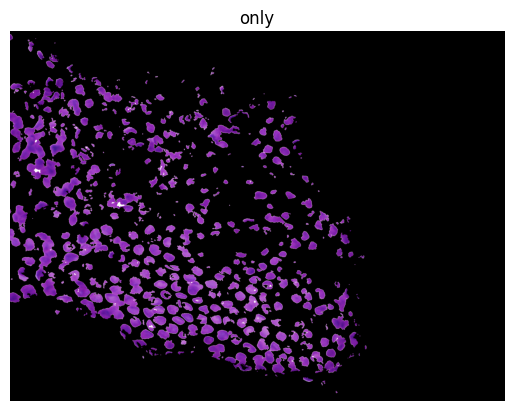

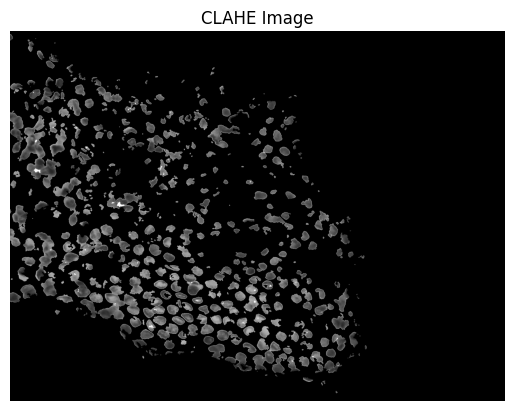

D:\studia\magisterka\myvenv\Lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=devi

[Cellpose] Saved segmentation figure to: D:\studia\magisterka\out\15b\15b_cellpose_masks.png


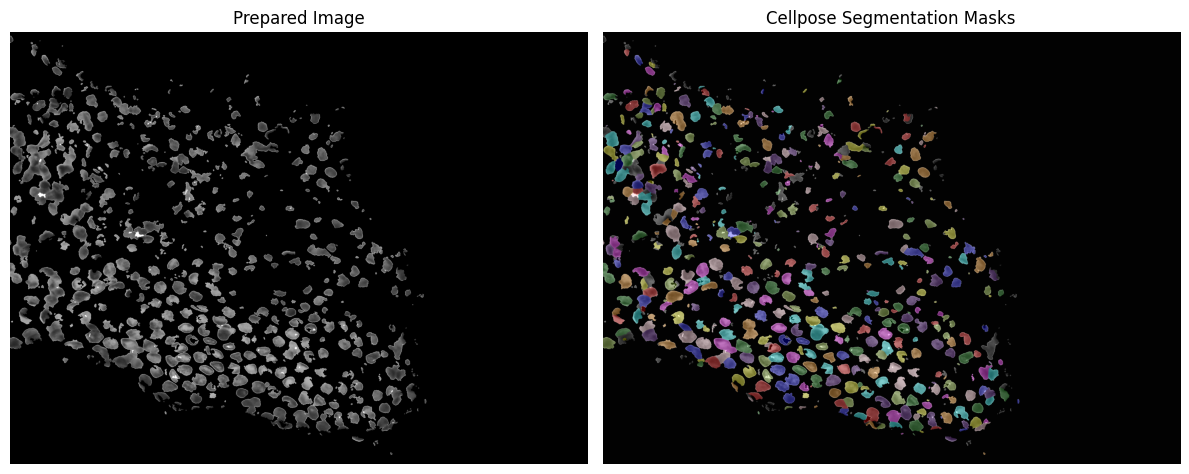

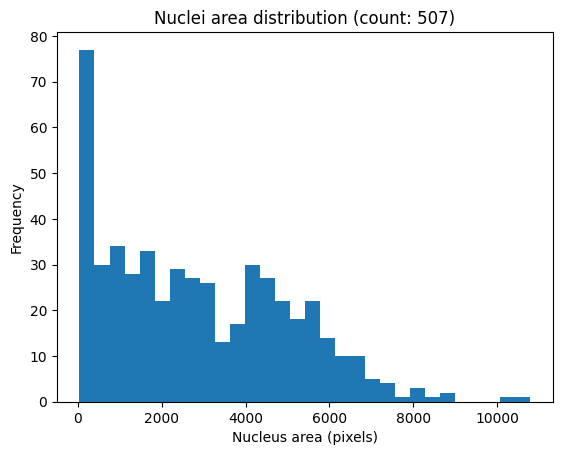

[Cellpose] Detected 507 nuclei.
[DEBUG] final_feature_vector:
   mean_intensity: 93.80919723418549 (type: <class 'float'>)
   std_intensity: 33.756940403814674 (type: <class 'float'>)
   skew_intensity: 2.1629135132572 (type: <class 'float'>)
   kurtosis_intensity: 9.127318107724777 (type: <class 'float'>)
   entropy_hist: 1.9979242284268945 (type: <class 'float'>)
   bounding_box_width: 47.872832369942195 (type: <class 'float'>)
   bounding_box_height: 42.59537572254335 (type: <class 'float'>)
   area: 1351.0693641618498 (type: <class 'float'>)
   perimeter: 152.26553406201302 (type: <class 'float'>)
   eccentricity: 0.6813229583480473 (type: <class 'float'>)
   solidity: 0.9181270174542484 (type: <class 'float'>)
   extent: 0.6696209908978829 (type: <class 'float'>)
   major_axis_length: 50.87057237394086 (type: <class 'float'>)
   minor_axis_length: 35.330728270495364 (type: <class 'float'>)
   circularity: 0.7361067560399563 (type: <class 'float'>)
   hu_moment_1: 0.181501808720573

In [124]:

output_dir = os.path.join(r"D:\studia\magisterka\out")
# for i in range (5, 45):
#     process_single_image(r"D:\studia\magisterka\FNA\G3\400x\{}b.bmp".format(i), output_dir)
process_single_image(r"D:\studia\magisterka\FNA\G1\400x\15b.bmp", output_dir)
# import os
# from PIL import Image


# def process_images_in_directory(directory):
#     for filename in os.listdir(directory):
#         if filename.endswith(".jpg"):
#             image_path = os.path.join(directory, filename)
#             process_single_image(image_path, output_dir)

# if __name__ == "__main__":
#     directory = r"D:\studia\magisterka\FNA\G2\400x\wybrane"
#     process_images_in_directory(directory)

In [ ]:
import os
import cv2

def process_all_images_in_folders(input_dir, output_dir, function_params):
    """
    Iterates through folders in the output directory and processes corresponding images.

    Parameters:
    ----------
    input_dir : str
        Path to the directory containing images (e.g., D:\studia\magisterka\FNA\G2\400x\wybrane).
    output_dir : str
        Path to the directory containing folders for each image (e.g., D:\studia\magisterka\out\G2).
    function_params : dict
        Parameters for the `process_and_visualize_he_image_blue_channel_with_morphology` function.
    """
    for folder_name in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Find the corresponding image in the input directory
            image_path = os.path.join(input_dir, f"{folder_name}.bmp")
            
            if not os.path.exists(image_path):
                print(f"[WARNING] Image {image_path} does not exist. Skipping...")
                continue
            
            try:
                print(f"Processing image: {image_path}")

                # 1. Process the image
                nuclei_on_white = process_and_visualize_he_image_blue_channel_with_morphology(
                    image_path=image_path,
                    save_intermediate=function_params.get('save_intermediate', False),
                    desired_size=function_params.get('desired_size', None),
                    apply_median_filter=function_params.get('apply_median_filter', True),
                    median_kernel_size=function_params.get('median_kernel_size', 3),
                    increase_contrast=function_params.get('increase_contrast', False),
                    alpha=function_params.get('alpha', 1.3),
                    beta=function_params.get('beta', 15),
                    adjust_blue_after_norm=function_params.get('adjust_blue_after_norm', True),
                    blue_factor=function_params.get('blue_factor', 1),
                    blue_offset=function_params.get('blue_offset', 0),
                    morph_kernel_size=function_params.get('morph_kernel_size', 3)
                )

                # 2. Extract nuclei
                only_nucleis_1 = extract_nuclei_only(nuclei_on_white)

                # 3. Optional fuzzy c-means segmentation (if uncommented)
                final_mask, masked_nuclei = fuzzy_cmeans_in_rgb_2clusters(only_nucleis_1)

                # 4. Save results in the folder
                nuclei_output_path = os.path.join(folder_path, f"{folder_name}_nuclei_on_white.png")
                cv2.imwrite(nuclei_output_path, cv2.cvtColor(nuclei_on_white, cv2.COLOR_BGR2RGB))

                nucleis_1_output_path = os.path.join(folder_path, f"{folder_name}_only_nucleis_1.png")
                cv2.imwrite(nucleis_1_output_path, cv2.cvtColor(only_nucleis_1, cv2.COLOR_BGR2RGB))

                nucleis_2_output_path = os.path.join(folder_path, f"{folder_name}_only_nucleis_2.png")
                cv2.imwrite(nucleis_2_output_path, cv2.cvtColor(masked_nuclei, cv2.COLOR_BGR2RGB))

                print(f"Results saved to folder: {folder_path}")

            except Exception as e:
                print(f"[ERROR] Error processing image {image_path}: {e}")

# Paths to directories
input_dir = r"D:\studia\magisterka\FNA\G3\400x"
output_dir = r"D:\studia\magisterka\out\G3"

# Function parameters
function_params = {
    'save_intermediate': False,
    'desired_size': None,
    'apply_median_filter': True,
    'median_kernel_size': 3,
    'increase_contrast': False,
    'alpha': 1.3,
    'beta': 15,
    'adjust_blue_after_norm': True,
    'blue_factor': 1,
    'blue_offset': 0,
    'morph_kernel_size': 3
}

# Execute the function
process_all_images_in_folders(input_dir, output_dir, function_params)


In [ ]:
import os
import glob
import pandas as pd

base_dir = r"D:\studia\magisterka\out"
all_data = []

# --------------------------------------------------
# Load files from folder G1 (last row)
# --------------------------------------------------
g1_path = os.path.join(base_dir, "G1", "*.csv")
for file_path in glob.glob(g1_path):
    df = pd.read_csv(file_path)
    # Take only the last row
    df_last = df.tail(1).copy()
    df_last["target"] = "G1"
    all_data.append(df_last)

# --------------------------------------------------
# Load files from folder G2 (last row)
# --------------------------------------------------
g2_path = os.path.join(base_dir, "G2")
for root, dirs, files in os.walk(g2_path):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            df = pd.read_csv(file_path)
            # Take only the last row
            df_last = df.tail(1).copy()
            df_last["target"] = "G2"
            all_data.append(df_last)

# --------------------------------------------------
# Load files from folder G3 (last row)
# --------------------------------------------------
g3_path = os.path.join(base_dir, "G3")
for root, dirs, files in os.walk(g3_path):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            df = pd.read_csv(file_path)
            # Take only the last row
            df_last = df.tail(1).copy()
            df_last["target"] = "G3"
            all_data.append(df_last)

# --------------------------------------------------
# Combine all last rows into a single table
# --------------------------------------------------
data = pd.concat(all_data, ignore_index=True)

# Preview data
print(data.head())
print(data.shape)


   GLCM_contrast  GLCM_correlation  GLCM_energy  GLCM_homogeneity  \
0      49.849571          0.906454     0.886567          0.920060   
1      39.542884          0.927559     0.872487          0.916230   
2      64.845469          0.926588     0.871896          0.909328   
3      23.246699          0.933532     0.901567          0.942066   
4      17.572659          0.920684     0.956591          0.967388   

   entropy_hist_0  entropy_hist_1  kurtosis_intensity_0  kurtosis_intensity_1  \
0        1.570195             NaN              2.963742                   NaN   
1        1.547592             NaN              2.339672                   NaN   
2        1.833164             NaN              1.888768                   NaN   
3        1.387707             NaN              3.832612                   NaN   
4        1.300526             NaN             11.344683                   NaN   

   mean_intensity_0  mean_intensity_1  skew_intensity_0  skew_intensity_1  \
0         29.463720  

In [ ]:

data_cleaned = data.loc[:, ~data.columns.str.endswith('_1')]

print(data_cleaned.head())
print(data_cleaned.shape)

data = data_cleaned

   GLCM_contrast  GLCM_correlation  GLCM_energy  GLCM_homogeneity  \
0      49.849571          0.906454     0.886567          0.920060   
1      39.542884          0.927559     0.872487          0.916230   
2      64.845469          0.926588     0.871896          0.909328   
3      23.246699          0.933532     0.901567          0.942066   
4      17.572659          0.920684     0.956591          0.967388   

   entropy_hist_0  kurtosis_intensity_0  mean_intensity_0  skew_intensity_0  \
0        1.570195              2.963742         29.463720          0.803794   
1        1.547592              2.339672         33.744598          0.505409   
2        1.833164              1.888768         47.665372          0.493879   
3        1.387707              3.832612         33.104629          1.060339   
4        1.300526             11.344683         28.114129          1.785469   

   std_intensity_0 target  
0        22.213986     G1  
1        21.810645     G1  
2        32.238223     G1 

--------------------------------------------------
METRYKI KLASYFIKACJI
--------------------------------------------------
Accuracy:            0.844
Balanced Accuracy:   0.848
Cohen's Kappa:       0.732
Matthews Corrcoef:   0.767
Precision (macro):   0.921
Recall (macro):      0.848
F1 (macro):          0.857

Classification Report:
               precision    recall  f1-score   support

          G1       1.00      1.00      1.00         5
          G2       1.00      0.55      0.71        11
          G3       0.76      1.00      0.86        16

    accuracy                           0.84        32
   macro avg       0.92      0.85      0.86        32
weighted avg       0.88      0.84      0.83        32

Confusion Matrix:
 [[ 5  0  0]
 [ 0  6  5]
 [ 0  0 16]]


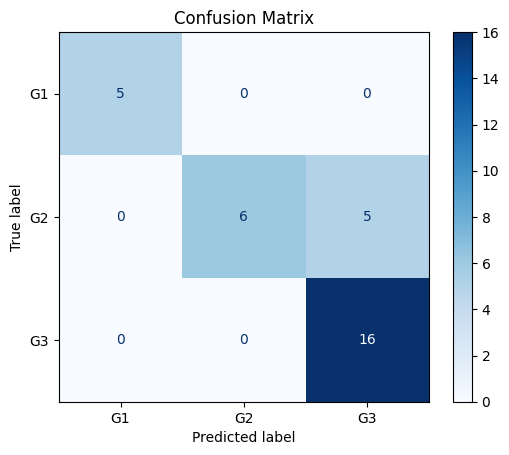

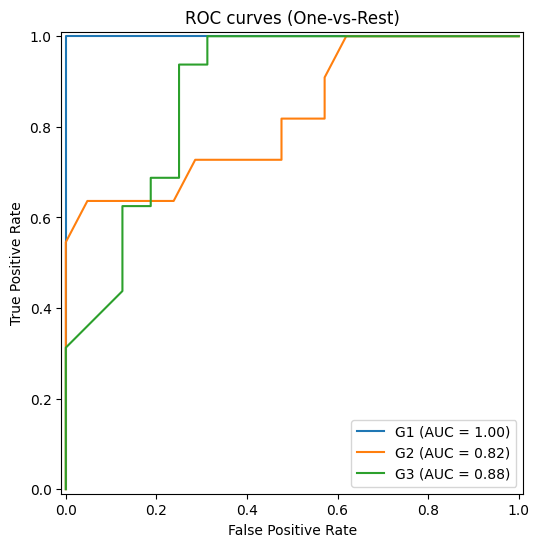

ROC AUC (macro, OvR): 0.900


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, cohen_kappa_score, 
    matthews_corrcoef, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# -----------------------------------------------------
# Load files from folder G1, G2, G3 (last row)
# -----------------------------------------------------
def load_last_row_from_folders(base_dir):
    all_data = []

    for group in ["G1", "G2", "G3"]:
        folder_path = os.path.join(base_dir, group)
        for root, dirs, files in os.walk(folder_path):
            for file_name in files:
                if file_name.endswith(".csv"):
                    file_path = os.path.join(root, file_name)
                    df = pd.read_csv(file_path)
                    # Take only the last row
                    df_last = df.tail(1).copy()
                    df_last["target"] = group
                    all_data.append(df_last)

    return pd.concat(all_data, ignore_index=True)

# Load data
base_dir = r"D:\studia\magisterka\out"
data = load_last_row_from_folders(base_dir)

# -----------------------------------------------------
# Prepare features (X) and labels (y)
# -----------------------------------------------------
X = data.drop(columns=["target"])
y = data["target"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------------------------------------
# Train a Random Forest model
# -----------------------------------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# -----------------------------------------------------
# Make predictions
# -----------------------------------------------------
y_pred = clf.predict(X_test)

# -----------------------------------------------------
# Calculate classification metrics
# -----------------------------------------------------
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("--------------------------------------------------")
print("CLASSIFICATION METRICS")
print("--------------------------------------------------")
print(f"Accuracy:            {acc:.3f}")
print(f"Balanced Accuracy:   {bal_acc:.3f}")
print(f"Cohen's Kappa:       {kappa:.3f}")
print(f"Matthews Corrcoef:   {mcc:.3f}")
print(f"Precision (macro):   {precision_macro:.3f}")
print(f"Recall (macro):      {recall_macro:.3f}")
print(f"F1 (macro):          {f1_macro:.3f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------------------------------
# Confusion matrix
# -----------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# -----------------------------------------------------
# ROC curves (One-vs-Rest)
# -----------------------------------------------------
# Get probabilities for each class
y_score = clf.predict_proba(X_test)

# Binarize labels for ROC computation
class_names = clf.classes_
y_test_bin = label_binarize(y_test, classes=class_names)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                    estimator_name=class_name).plot(ax=plt.gca())

plt.title("ROC curves (One-vs-Rest)")
plt.show()

# Compute macro-average ROC AUC
roc_auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
print(f"ROC AUC (macro, OvR): {roc_auc_macro:.3f}")


In [ ]:


base_dir = r"D:\studia\magisterka\out"
all_data = []

g1_path = os.path.join(base_dir, "G1_larger")
for root, dirs, files in os.walk(g1_path):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            df = pd.read_csv(file_path)
            df_last = df.tail(1).copy()
            df_last["target"] = "G1"
            all_data.append(df_last)

g2_path = os.path.join(base_dir, "G2_larger")
for root, dirs, files in os.walk(g2_path):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            df = pd.read_csv(file_path)
            df_last = df.tail(1).copy()
            df_last["target"] = "G2"
            all_data.append(df_last)

g3_path = os.path.join(base_dir, "G3_larger")
for root, dirs, files in os.walk(g3_path):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            df = pd.read_csv(file_path)
            # Bierzemy tylko ostatni wiersz
            df_last = df.tail(1).copy()
            df_last["target"] = "G3"
            all_data.append(df_last)


data = pd.concat(all_data, ignore_index=True)


print(data.head())
print(data.shape)


# data.to_csv(r"D:\studia\magisterka\out\all_data.csv", index=False)

   mean_intensity  std_intensity  skew_intensity  kurtosis_intensity  \
0       56.122941      15.928951       -1.182401            5.338186   
1       50.749038      10.424170       -0.992506            5.682846   
2       64.121158      15.915347       -2.132723            8.135275   
3       44.550129       5.513379       -0.772402            6.180891   
4       56.682217      12.750582       -0.886532            5.524097   

   entropy_hist  bounding_box_width  bounding_box_height         area  \
0      1.684023           40.920635            38.857143  1034.095238   
1      1.167562           49.109890            50.032967  1702.318681   
2      1.510994           35.209677            31.661290   759.225806   
3      0.839720           49.084507            48.211268  1582.309859   
4      1.544012           44.850746            44.208955  1378.253731   

    perimeter  eccentricity  ...  max_GLCM_energy  cv_GLCM_correlation  \
0  133.851149      0.713602  ...         0.999999     

--------------------------------------------------
WYNIKI KROSWALIDACJI (5-FOLD) NA ZBIORZE TRENINGOWYM
--------------------------------------------------
CV Accuracy (mean):            0.795
CV Balanced Accuracy (mean):   0.822
CV Precision Macro (mean):     0.844
CV Recall Macro (mean):        0.822
CV F1 Macro (mean):            0.828
CV MCC (mean):                 0.664

--------------------------------------------------
METRYKI KLASYFIKACJI NA ZBIORZE TESTOWYM
--------------------------------------------------
Accuracy:            0.871
Balanced Accuracy:   0.894
Cohen's Kappa:       0.782
Matthews Corrcoef:   0.788
Precision (macro):   0.908
Recall (macro):      0.894
F1 (macro):          0.898

Classification Report (test):
               precision    recall  f1-score   support

          G1       1.00      1.00      1.00         4
          G2       0.90      0.75      0.82        12
          G3       0.82      0.93      0.88        15

    accuracy                           0

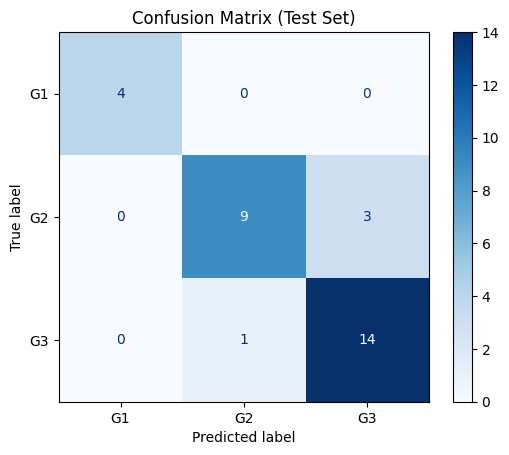

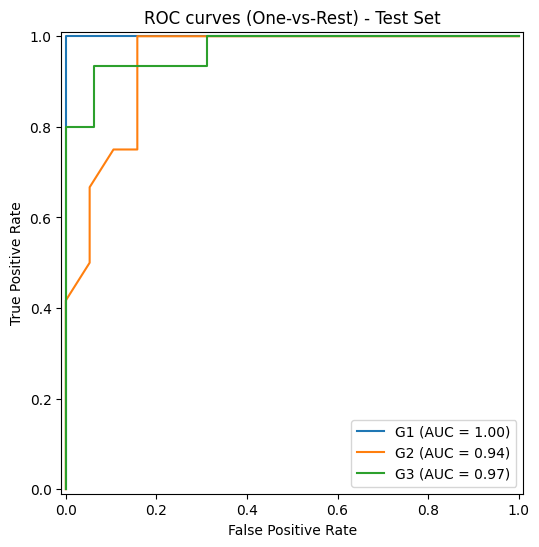

ROC AUC (macro, OvR, test): 0.971


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, cohen_kappa_score, 
    matthews_corrcoef, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
)

# Data preparation
X = data.drop(columns=["target"])
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=22,
    stratify=y
)

# Cross-validation
clf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'mcc': make_scorer(matthews_corrcoef)
}

cv_results = cross_validate(
    estimator=clf_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

cv_accuracy_mean = np.mean(cv_results['test_accuracy'])
cv_bal_acc_mean = np.mean(cv_results['test_balanced_accuracy'])
cv_f1_macro_mean = np.mean(cv_results['test_f1_macro'])
cv_precision_macro_mean = np.mean(cv_results['test_precision_macro'])
cv_recall_macro_mean = np.mean(cv_results['test_recall_macro'])
cv_mcc_mean = np.mean(cv_results['test_mcc'])

print("Cross-Validation Results (5-Fold):")
print(f"Accuracy (mean):            {cv_accuracy_mean:.3f}")
print(f"Balanced Accuracy (mean):   {cv_bal_acc_mean:.3f}")
print(f"Precision Macro (mean):     {cv_precision_macro_mean:.3f}")
print(f"Recall Macro (mean):        {cv_recall_macro_mean:.3f}")
print(f"F1 Macro (mean):            {cv_f1_macro_mean:.3f}")
print(f"MCC (mean):                 {cv_mcc_mean:.3f}")

# Training on the entire training set
clf_final = RandomForestClassifier(n_estimators=100, random_state=42)
clf_final.fit(X_train, y_train)

# Predictions on the test set
y_pred = clf_final.predict(X_test)

# Test set evaluation
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("\nTest Set Metrics:")
print(f"Accuracy:            {acc:.3f}")
print(f"Balanced Accuracy:   {bal_acc:.3f}")
print(f"Cohen's Kappa:       {kappa:.3f}")
print(f"Matthews Corrcoef:   {mcc:.3f}")
print(f"Precision (macro):   {precision_macro:.3f}")
print(f"Recall (macro):      {recall_macro:.3f}")
print(f"F1 (macro):          {f1_macro:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf_final.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ROC curves
y_score = clf_final.predict_proba(X_test)
class_names = clf_final.classes_
y_test_bin = label_binarize(y_test, classes=class_names)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    RocCurveDisplay(
        fpr=fpr, tpr=tpr, roc_auc=roc_auc,
        estimator_name=class_name
    ).plot(ax=plt.gca())
    
plt.title("ROC Curves (One-vs-Rest) - Test Set")
plt.show()

roc_auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
print(f"ROC AUC (macro, OvR, test): {roc_auc_macro:.3f}")


Feature ranking (top 20):
1. GLCM_homogeneity (0.0363)
2. GLCM_energy (0.0312)
3. cv_GLCM_homogeneity (0.0288)
4. GLCM_contrast (0.0244)
5. std_GLCM_contrast (0.0235)
6. max_mean_intensity (0.0228)
7. std_GLCM_energy (0.0224)
8. cv_GLCM_energy (0.0224)
9. std_GLCM_homogeneity (0.0211)
10. min_GLCM_homogeneity (0.0204)
11. max_GLCM_contrast (0.0202)
12. std_bounding_box_width (0.0134)
13. max_major_axis_length (0.0116)
14. cv_zernike_18 (0.0111)
15. max_perimeter (0.0108)
16. max_area (0.0106)
17. std_kurtosis_intensity (0.0104)
18. major_axis_length (0.0103)
19. cv_zernike_9 (0.0103)
20. max_zernike_15 (0.0101)

Wyniki dla różnych liczności wybranych cech:
    num_features  accuracy  f1_macro       mcc
0              5  0.806452  0.822158  0.684400
1             10  0.806452  0.824311  0.694640
2             20  0.838710  0.875862  0.733568
3             25  0.806452  0.818290  0.683395
4             30  0.838710  0.873773  0.730787
5             40  0.870968  0.900000  0.784722
6     

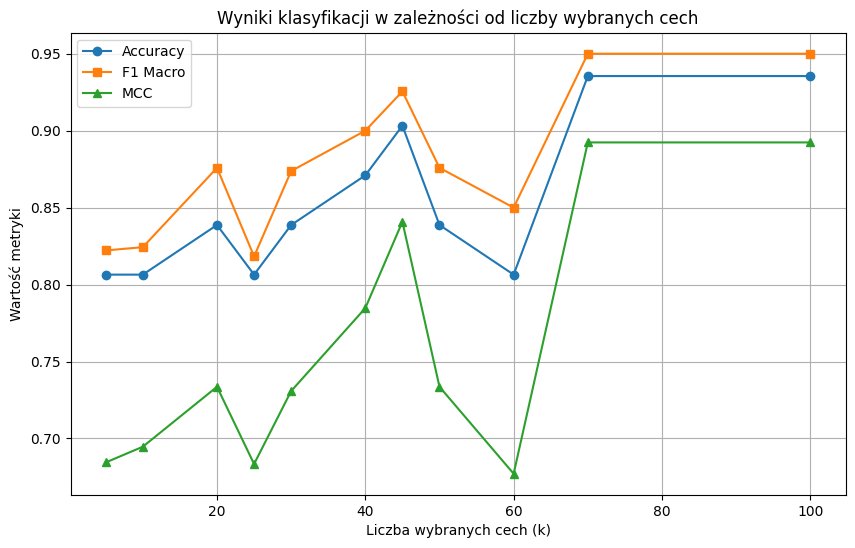


Wyniki zostały zapisane do pliku 'wyniki_ranking_cech.csv'.


In [130]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt

# 1. Assume 'data' is a DataFrame with 'target' as the label column
X = data.drop(columns=["target"])
y = data["target"]

# 2. Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Train the model on all features to obtain feature importance
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

# 4. Calculate and sort feature importances
importances = base_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]  # descending order
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# Display the top 20 features
print("Feature ranking (top 20):")
for i in range(20):
    print(f"{i+1}. {sorted_features[i]} ({sorted_importances[i]:.4f})")

# 5. Define thresholds (number of features) to test
feature_counts = [5, 10, 20, 25, 30, 40, 45, 50, 60, 70, 100]

results = []

for k in feature_counts:
    # Select top-k features
    top_k_features = sorted_features[:k]
    
    # Create subsets with top-k features
    X_train_k = X_train[top_k_features]
    X_test_k = X_test[top_k_features]
    
    # Train model on top-k features
    model_k = RandomForestClassifier(n_estimators=100, random_state=42)
    model_k.fit(X_train_k, y_train)
    
    # Evaluate on the test set
    y_pred_test = model_k.predict(X_test_k)
    
    acc = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred_test)
    
    # Save results
    results.append({
        'num_features': k,
        'accuracy': acc,
        'f1_macro': f1,
        'mcc': mcc
    })

# 6. Create a DataFrame with results and display it
results_df = pd.DataFrame(results)
print("\nResults for different numbers of selected features:")
print(results_df)

# 7. Optionally, select the best k (e.g., by F1 score)
best_k = results_df.loc[results_df['f1_macro'].idxmax(), 'num_features']
print(f"\nBest k (based on macro-F1): {best_k}")

# 8. Plot metrics vs number of features
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['num_features'], results_df['f1_macro'], marker='s', label='F1 Macro')
plt.plot(results_df['num_features'], results_df['mcc'], marker='^', label='MCC')
plt.xlabel('Number of selected features (k)')
plt.ylabel('Metric value')
plt.title('Classification results vs number of selected features')
plt.grid(True)
plt.legend()
plt.show()

# 9. Save results to a CSV file
results_df.to_csv("feature_ranking_results.csv", index=False)
print("\nResults saved to 'feature_ranking_results.csv'.")


Feature ranking (top 20):
1. GLCM_homogeneity (0.0363)
2. GLCM_energy (0.0312)
3. cv_GLCM_homogeneity (0.0288)
4. GLCM_contrast (0.0244)
5. std_GLCM_contrast (0.0235)
6. max_mean_intensity (0.0228)
7. std_GLCM_energy (0.0224)
8. cv_GLCM_energy (0.0224)
9. std_GLCM_homogeneity (0.0211)
10. min_GLCM_homogeneity (0.0204)

Wyniki kroswalidacji (średnie) dla różnych liczności wybranych cech:
    num_features  cv_accuracy  cv_f1_macro    cv_mcc
0              5     0.810667     0.848778  0.687027
1             10     0.802333     0.834235  0.673470
2             20     0.819333     0.843424  0.704435
3             25     0.786667     0.819709  0.644073
4             30     0.844000     0.877273  0.742386
5             40     0.786333     0.823036  0.646495
6             45     0.819333     0.856746  0.701609
7             50     0.803333     0.843284  0.674862
8             60     0.819000     0.847256  0.697168
9             70     0.819333     0.847830  0.700851
10            80     0.8120

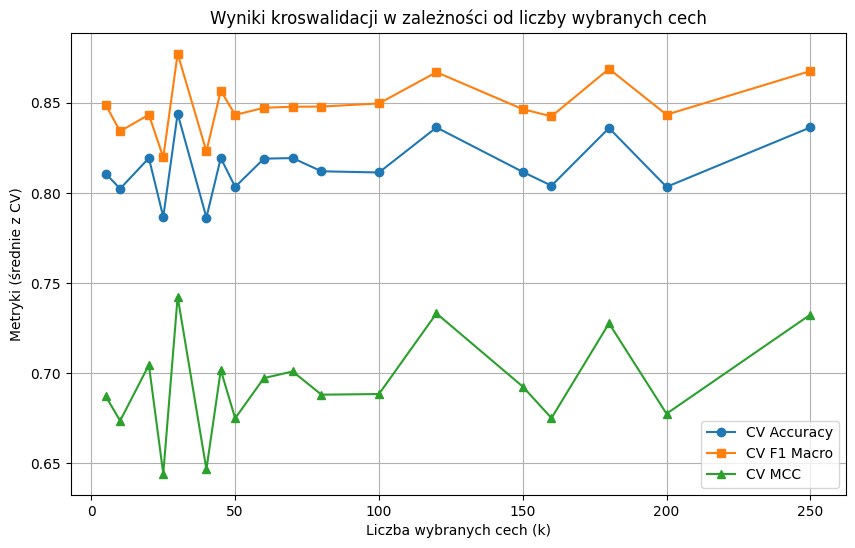


Wyniki kroswalidacji zapisano do pliku 'wyniki_kroswalidacja_cech.csv'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, make_scorer

# ========= 1) Data Preparation =========
# Assume 'data' is a DataFrame with no missing values and 'target' is the class label column
X = data.drop(columns=["target"])
y = data["target"]

# Split data into training and testing sets (e.g., 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========= 2) Feature Ranking on Full Dataset =========
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

importances = base_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

print("Feature ranking (top 20):")
for i in range(min(10, len(sorted_features))):
    print(f"{i+1}. {sorted_features[i]} ({sorted_importances[i]:.4f})")

# ========= 3) Cross-Validation for Different Feature Counts =========
# Define different feature counts to test
feature_counts = [5, 10, 20, 25, 30, 40, 45, 50, 60, 70, 80, 100, 120, 150, 160, 180, 200, 250]

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scorers for cross-validation
mcc_scorer = make_scorer(matthews_corrcoef)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'mcc': mcc_scorer
}

results = []

for k in feature_counts:
    top_k_features = sorted_features[:k]

    # Create a subset with top-k features
    X_train_k = X_train[top_k_features]

    # Define the model
    model_k = RandomForestClassifier(n_estimators=100, random_state=42)

    # Perform cross-validation
    cv_scores = cross_validate(
        model_k, X_train_k, y_train,
        cv=cv, scoring=scoring, n_jobs=-1
    )

    acc_mean = np.mean(cv_scores['test_accuracy'])
    f1_mean = np.mean(cv_scores['test_f1_macro'])
    mcc_mean = np.mean(cv_scores['test_mcc'])

    results.append({
        'num_features': k,
        'cv_accuracy': acc_mean,
        'cv_f1_macro': f1_mean,
        'cv_mcc': mcc_mean
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results (averages) for different feature counts:")
print(results_df)

# ========= 4) Selecting the Best k =========
# Example: Select k based on the highest F1-macro score in cross-validation
best_k = results_df.loc[results_df['cv_f1_macro'].idxmax(), 'num_features']
print(f"\nBest k (based on F1-macro in CV): {best_k}")

# ========= 5) Train Final Model and Test ============
# Create final subset of features (top-best_k) on the full training set
final_features = sorted_features[:best_k]
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train_final, y_train)

y_pred_test = final_model.predict(X_test_final)

test_acc = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
test_mcc = matthews_corrcoef(y_test, y_pred_test)

print(f"\n=== Test Set Results for k={best_k} Features ===")
print(f"Accuracy:  {test_acc:.3f}")
print(f"F1-macro:  {test_f1:.3f}")
print(f"MCC:       {test_mcc:.3f}")

# ========= 6) Cross-Validation Plot (Accuracy, F1, MCC vs k) ============
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['cv_accuracy'], marker='o', label='CV Accuracy')
plt.plot(results_df['num_features'], results_df['cv_f1_macro'], marker='s', label='CV F1 Macro')
plt.plot(results_df['num_features'], results_df['cv_mcc'], marker='^', label='CV MCC')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Metrics (CV Averages)')
plt.title('Cross-Validation Results vs Number of Selected Features')
plt.grid(True)
plt.legend()
plt.show()

# ========= 7) Save Cross-Validation Results to CSV ==========
results_df.to_csv("cross_validation_feature_ranking_results.csv", index=False)
print("\nCross-validation results saved to 'cross_validation_feature_ranking_results.csv'.")


D:\studia\magisterka\myvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\studia\magisterka\myvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Zebrane cechy: (153, 512)
Zebrane etykiety: (153,)
Zapisano cechy do pliku: features_resnet18.csv

=== WYNIKI KROSWALIDACJI (5-FOLD) NA TRAIN ===
CV Accuracy (mean):         0.738
CV Precision Macro (mean):  0.787
CV Recall Macro (mean):     0.722
CV F1 Macro (mean):         0.732
CV MCC (mean):              0.563

=== METRYKI NA ZBIORZE TESTOWYM ===
Accuracy:         0.806
Precision(macro): 0.796
Recall(macro):    0.794
F1(macro):        0.792
MCC:              0.685

=== Classification report ===
              precision    recall  f1-score   support

           0      0.750     0.750     0.750         4
           1      0.714     0.833     0.769        12
           2      0.923     0.800     0.857        15

    accuracy                          0.806        31
   macro avg      0.796     0.794     0.792        31
weighted avg      0.820     0.806     0.809        31


Confusion Matrix:
 [[ 3  1  0]
 [ 1 10  1]
 [ 0  3 12]]


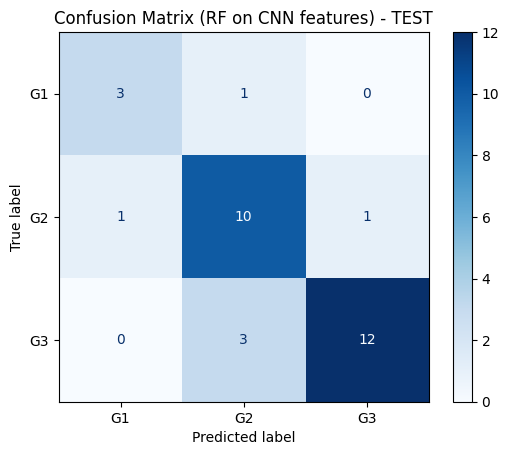

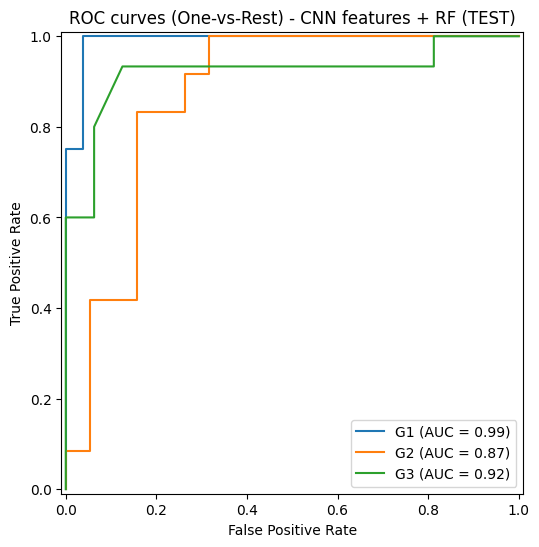

ROC AUC (macro, OvR, TEST): 0.927


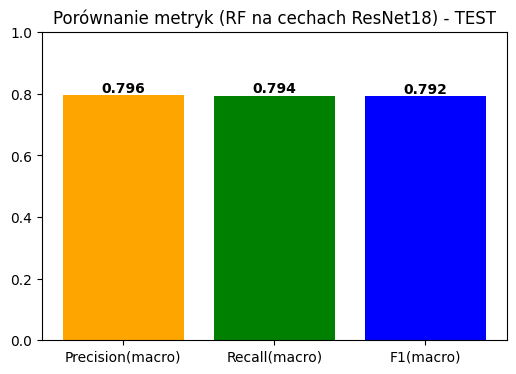

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, matthews_corrcoef,
    roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay,
    make_scorer
)
from sklearn.preprocessing import label_binarize

# -----------------------------------------------------
# 1. PATHS / CONFIGURATION
# -----------------------------------------------------
base_dir = r"D:\studia\magisterka\out"
subdirs = ["G1_larger", "G2_larger", "G3_larger"]  # subdirectories to search

label_map = {
    "G1_larger": 0,
    "G2_larger": 1,
    "G3_larger": 2
}

# Transformations for ResNet (e.g., ResNet18)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# -----------------------------------------------------
# 2. LOADING MODEL (RESNET18) - Removing the last layer
# -----------------------------------------------------
model = models.resnet18(pretrained=True)
model.fc = nn.Identity()  # Replace FC with identity: output will be a feature vector (512-d)

model.eval()  # evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# -----------------------------------------------------
# 3. RECURSIVE SEARCH FOR _pre_segmented.png AND FEATURE EXTRACTION
# -----------------------------------------------------
features_list = []
labels_list = []

for subdir in subdirs:
    subdir_path = os.path.join(base_dir, subdir)
    
    for root, dirs, files in os.walk(subdir_path):
        for fname in files:
            if fname.endswith("_pre_segmented.png"):
                file_path = os.path.join(root, fname)
                
                pil_img = Image.open(file_path).convert("RGB")
                input_tensor = image_transform(pil_img)
                input_tensor = input_tensor.unsqueeze(0).to(device)  # (1,3,224,224)
                
                with torch.no_grad():
                    output = model(input_tensor)  # [1, 512] for ResNet18
                feat = output.squeeze().cpu().numpy()  # Convert to NumPy
                
                features_list.append(feat)
                labels_list.append(label_map[subdir])

features_np = np.array(features_list)  # (N, 512)
labels_np = np.array(labels_list)

print("Collected features:", features_np.shape)
print("Collected labels:", labels_np.shape)

# -----------------------------------------------------
# 4. CREATING DATAFRAME / OPTIONAL CSV SAVE
# -----------------------------------------------------
df_features = pd.DataFrame(features_np)
df_features["label"] = labels_np

df_features.to_csv("features_resnet18.csv", index=False)
print("Features saved to file: features_resnet18.csv")

# -----------------------------------------------------
# 5. TRAIN/TEST SPLIT
# -----------------------------------------------------
X = df_features.drop(columns=["label"])
y = df_features["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------------------
# 5.1 CROSS-VALIDATION ON TRAINING SET
# -----------------------------------------------------
clf_cv = RandomForestClassifier(n_estimators=100, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'mcc': make_scorer(matthews_corrcoef)
}

cv_results = cross_validate(clf_cv, X_train, y_train,
                            cv=cv, scoring=scoring,
                            return_train_score=False)

cv_accuracy_mean = cv_results['test_accuracy'].mean()
cv_precision_macro_mean = cv_results['test_precision_macro'].mean()
cv_recall_macro_mean = cv_results['test_recall_macro'].mean()
cv_f1_macro_mean = cv_results['test_f1_macro'].mean()
cv_mcc_mean = cv_results['test_mcc'].mean()

print("\n=== CROSS-VALIDATION RESULTS (5-FOLD) ON TRAIN ===")
print(f"CV Accuracy (mean):         {cv_accuracy_mean:.3f}")
print(f"CV Precision Macro (mean):  {cv_precision_macro_mean:.3f}")
print(f"CV Recall Macro (mean):     {cv_recall_macro_mean:.3f}")
print(f"CV F1 Macro (mean):         {cv_f1_macro_mean:.3f}")
print(f"CV MCC (mean):              {cv_mcc_mean:.3f}")

# -----------------------------------------------------
# 5.2 FINAL TRAINING ON FULL TRAIN SET AND TESTING
# -----------------------------------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# -----------------------------------------------------
# 6. EVALUATION ON TEST SET
# -----------------------------------------------------
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
mcc = matthews_corrcoef(y_test, y_pred)

print("\n=== TEST SET METRICS ===")
print(f"Accuracy:         {accuracy:.3f}")
print(f"Precision(macro): {precision_macro:.3f}")
print(f"Recall(macro):    {recall_macro:.3f}")
print(f"F1(macro):        {f1_macro:.3f}")
print(f"MCC:              {mcc:.3f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

# -----------------------------------------------------
# 7. CONFUSION MATRIX
# -----------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(cm, display_labels=["G1", "G2", "G3"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (RF on CNN features) - TEST")
plt.show()

# -----------------------------------------------------
# 8. MULTICLASS ROC AUC AND PLOT
# -----------------------------------------------------
y_proba = clf.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(["G1", "G2", "G3"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=class_name).plot(ax=plt.gca())

plt.title("ROC Curves (One-vs-Rest) - CNN Features + RF (TEST)")
plt.show()

roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
print(f"ROC AUC (macro, OvR, TEST): {roc_auc_macro:.3f}")

# -----------------------------------------------------
# 9. METRICS COMPARISON BAR PLOT
# -----------------------------------------------------
metrics_names = ["Precision(macro)", "Recall(macro)", "F1(macro)"]
metrics_values = [precision_macro, recall_macro, f1_macro]

plt.figure(figsize=(6, 4))
plt.bar(metrics_names, metrics_values, color=["orange", "green", "blue"])
plt.ylim([0, 1])
plt.title("Metrics Comparison (RF on ResNet18 Features) - TEST")
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()


In [133]:
# data = DataFrame with classical features + 'target' column
# df_features = DataFrame with CNN features + 'label' column
print("data shape:", data.shape)
print("df_features shape:", df_features.shape)

# Check if the number of rows matches
assert data.shape[0] == df_features.shape[0], "The number of rows in 'data' and 'df_features' does not match!"

# Extract classical features from 'data' (excluding 'target' column)
classical_features = data.drop(columns=['target'])

# Extract CNN features from 'df_features' (excluding 'label' column)
cnn_features = df_features.drop(columns=['label'])

# Combine horizontally (axis=1)
combined_features = pd.concat([classical_features, cnn_features], axis=1)

# Target labels (e.g., from 'data')
combined_label = data['target']

# Now we have:
# combined_features -> all features
# combined_label    -> labels
print("combined_features shape:", combined_features.shape)

# You can also combine everything into a single DataFrame, e.g.:
combined_df = combined_features.copy()
combined_df['target'] = combined_label

# Optionally, save to a CSV file
combined_df.to_csv("combined_features.csv", index=False)


data shape: (153, 261)
df_features shape: (153, 513)
combined_features shape: (153, 772)


Feature ranking (top 20):
1. cv_GLCM_homogeneity (0.0239)
2. std_GLCM_contrast (0.0221)
3. min_GLCM_homogeneity (0.0214)
4. std_GLCM_energy (0.0210)
5. GLCM_homogeneity (0.0188)
6. GLCM_contrast (0.0148)
7. std_GLCM_homogeneity (0.0144)
8. 120 (0.0127)
9. min_GLCM_energy (0.0116)
10. 218 (0.0108)

Cross-validation results (averages) for different feature counts:
    num_features  cv_accuracy  cv_f1_macro    cv_mcc
0             50     0.852667     0.883094  0.765728
1             60     0.827667     0.855887  0.719288
2             70     0.827667     0.846711  0.719946
3             80     0.869000     0.887841  0.790795
4             90     0.844333     0.877944  0.748959
..           ...          ...          ...       ...
67           720     0.795000     0.828105  0.665350
68           730     0.787333     0.819341  0.653731
69           740     0.770667     0.805582  0.618695
70           750     0.820000     0.856263  0.704524
71           760     0.829000     0.844310  0.730232

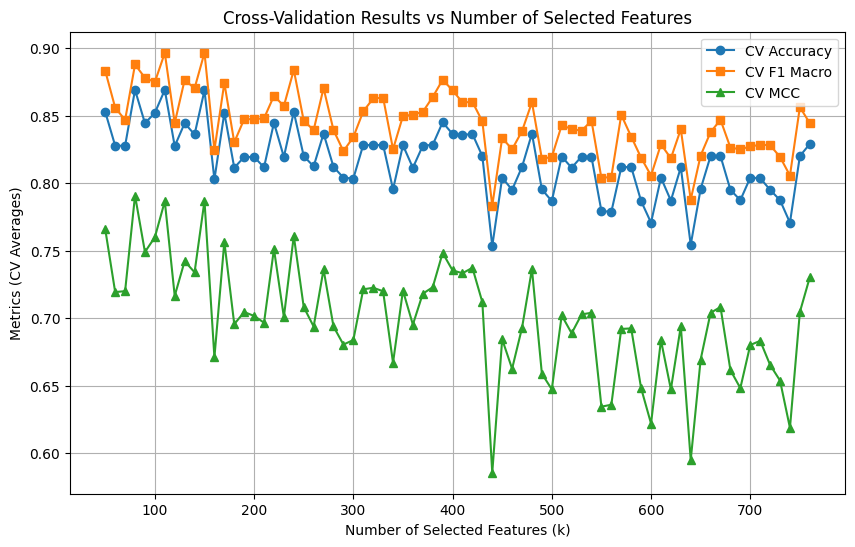


Cross-validation results saved to 'cross_validation_feature_results.csv'.


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, make_scorer

# --------------------------------------------------
# 1) Data Preparation
# --------------------------------------------------
# Assume 'combined_df' is a DataFrame where 'target' is the label column.
X = combined_df.drop(columns=["target"])
y = combined_df["target"]

# Split data into training and testing sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# --------------------------------------------------
# 2) Feature Importance Ranking
# --------------------------------------------------
# Train a Random Forest model to compute feature importance.
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

# Extract feature importances and sort them in descending order.
importances = base_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# Display the top 20 features.
print("Feature ranking (top 20):")
for i in range(min(10, len(sorted_features))):
    print(f"{i+1}. {sorted_features[i]} ({sorted_importances[i]:.4f})")

# --------------------------------------------------
# 3) Cross-Validation for Different Feature Counts
# --------------------------------------------------
# Define different numbers of features (k) to test.
feature_counts = list(range(50, 761, 10))

# Set up 5-fold stratified cross-validation.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics for cross-validation.
mcc_scorer = make_scorer(matthews_corrcoef)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'mcc': mcc_scorer
}

# Perform cross-validation for different feature counts.
results = []
for k in feature_counts:
    top_k_features = sorted_features[:k]

    # Create a subset with the top-k features.
    X_train_k = X_train[top_k_features]

    # Train a Random Forest model with the selected features.
    model_k = RandomForestClassifier(n_estimators=100, random_state=42)

    # Perform cross-validation.
    cv_scores = cross_validate(
        model_k, X_train_k, y_train,
        cv=cv, scoring=scoring, n_jobs=-1
    )

    # Record the average metrics from cross-validation.
    acc_mean = np.mean(cv_scores['test_accuracy'])
    f1_mean = np.mean(cv_scores['test_f1_macro'])
    mcc_mean = np.mean(cv_scores['test_mcc'])

    results.append({
        'num_features': k,
        'cv_accuracy': acc_mean,
        'cv_f1_macro': f1_mean,
        'cv_mcc': mcc_mean
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results (averages) for different feature counts:")
print(results_df)

# --------------------------------------------------
# 4) Selecting the Best k
# --------------------------------------------------
# Select the best k based on the highest F1-macro score in cross-validation.
best_k = results_df.loc[results_df['cv_f1_macro'].idxmax(), 'num_features']
print(f"\nBest k (based on F1-macro in CV): {best_k}")

# --------------------------------------------------
# 5) Train Final Model and Evaluate on Test Set
# --------------------------------------------------
# Create a feature subset with the top-best_k features.
final_features = sorted_features[:best_k]
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

# Train the final Random Forest model.
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train_final, y_train)

# Evaluate the model on the test set.
y_pred_test = final_model.predict(X_test_final)

test_acc = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
test_mcc = matthews_corrcoef(y_test, y_pred_test)

print(f"\n=== Test Set Results for k={best_k} Features ===")
print(f"Accuracy:  {test_acc:.3f}")
print(f"F1-macro:  {test_f1:.3f}")
print(f"MCC:       {test_mcc:.3f}")

# --------------------------------------------------
# 6) Cross-Validation Metrics Plot (Accuracy, F1, MCC vs k)
# --------------------------------------------------
# Plot metrics from cross-validation for different feature counts.
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['cv_accuracy'], marker='o', label='CV Accuracy')
plt.plot(results_df['num_features'], results_df['cv_f1_macro'], marker='s', label='CV F1 Macro')
plt.plot(results_df['num_features'], results_df['cv_mcc'], marker='^', label='CV MCC')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Metrics (CV Averages)')
plt.title('Cross-Validation Results vs Number of Selected Features')
plt.grid(True)
plt.legend()
plt.show()

# --------------------------------------------------
# 7) Save Cross-Validation Results to CSV
# --------------------------------------------------
# Save the cross-validation results to a CSV file.
results_df.to_csv("cross_validation_feature_results.csv", index=False)
print("\nCross-validation results saved to 'cross_validation_feature_results.csv'.")



Wyniki kroswalidacji (średnie) dla różnych liczności wybranych cech:
    num_features  cv_accuracy  cv_f1_macro    cv_mcc
0             50     0.830538     0.837028  0.725848
1             60     0.836774     0.853947  0.732123
2             70     0.823871     0.840722  0.711647
3             80     0.849677     0.871962  0.756748
4             90     0.863011     0.871726  0.777283
..           ...          ...          ...       ...
66           710     0.862581     0.866219  0.778574
67           720     0.862581     0.869723  0.777854
68           730     0.862581     0.870093  0.778230
69           740     0.869247     0.875271  0.786594
70           750     0.862796     0.862416  0.778566

[71 rows x 4 columns]

Najlepsze k (pod względem F1-macro w CV): 280


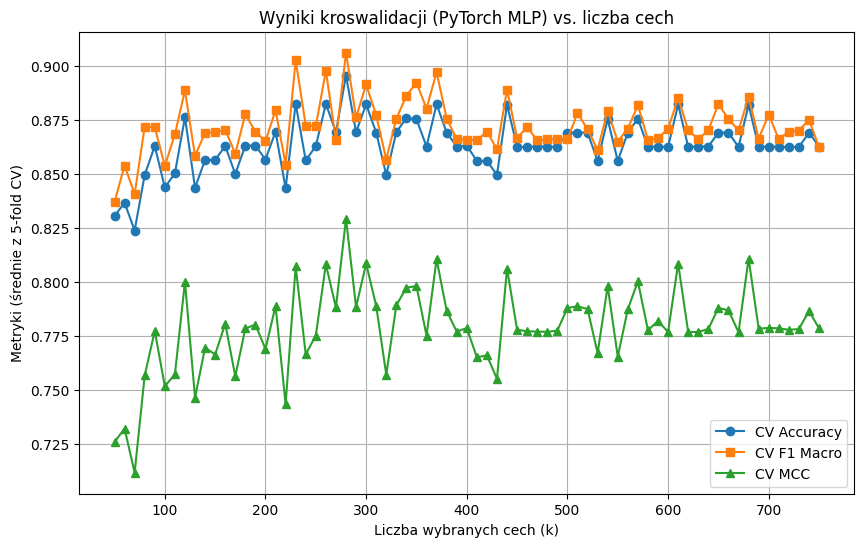

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Encode string labels in the 'target' column to integers
le = LabelEncoder()
combined_df["target"] = le.fit_transform(combined_df["target"])

# --------------------------------------------------
# 1) Data Preparation
# --------------------------------------------------

# Assume `combined_df` is a DataFrame where 'target' is the class label
# Ensure 'target' is of int/float type. If it's a string, encode it into integers.

X = combined_df.drop(columns=["target"])
y = combined_df["target"].values  # Convert to NumPy array

# Convert column names to strings (if column names are integers)
X.columns = X.columns.astype(str)

# Standardize the data (optional but often helpful for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a range of feature counts (from 50 to 750 with a step of 10)
feature_counts = list(range(50, 751, 10))

# --------------------------------------------------
# 2) Define a Simple Neural Network in PyTorch
# --------------------------------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)

# Function for training one epoch
def train_one_epoch(model, optimizer, criterion, X_train_tensor, y_train_tensor, batch_size=32):
    model.train()
    dataset_size = X_train_tensor.size(0)
    
    # Shuffle indices
    indices = torch.randperm(dataset_size)
    
    # Mini-batch loop
    for start_idx in range(0, dataset_size, batch_size):
        end_idx = min(start_idx + batch_size, dataset_size)
        batch_indices = indices[start_idx:end_idx]
        
        X_batch = X_train_tensor[batch_indices]
        y_batch = y_train_tensor[batch_indices]
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Function to evaluate the model
def evaluate_model(model, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor)
        # Take argmax since the model outputs logits
        predictions = outputs.argmax(dim=1).cpu().numpy()
        y_true = y_val_tensor.cpu().numpy()
        
        acc = accuracy_score(y_true, predictions)
        f1 = f1_score(y_true, predictions, average='macro')
        mcc = matthews_corrcoef(y_true, predictions)
    
    return acc, f1, mcc

importances = base_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# --------------------------------------------------
# 4) Cross-Validation with Neural Network
# --------------------------------------------------
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in feature_counts:
    # Select top-k features
    top_k_features = sorted_features[:k]
    
    # Extract the top-k columns from the scaled data
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    X_k = X_scaled_df[top_k_features].values
    
    # Lists to store metrics for this fold
    fold_accuracies = []
    fold_f1s = []
    fold_mccs = []
    
    # Loop through folds
    for train_idx, val_idx in cv.split(X_k, y):
        # Split data into train/validation sets
        X_train_fold, X_val_fold = X_k[train_idx], X_k[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_tensor   = torch.tensor(X_val_fold,   dtype=torch.float32)
        y_val_tensor   = torch.tensor(y_val_fold,   dtype=torch.long)
        
        # Define the model
        output_dim = len(np.unique(y))  # Number of classes
        model = SimpleMLP(input_dim=k, hidden_dim=64, output_dim=output_dim)
        
        # Optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        
        # Train the model (e.g., for 20 epochs)
        n_epochs = 20
        for epoch in range(n_epochs):
            train_one_epoch(model, optimizer, criterion, X_train_tensor, y_train_tensor, batch_size=32)
        
        # Evaluate the model
        acc, f1, mcc = evaluate_model(model, X_val_tensor, y_val_tensor)
        
        fold_accuracies.append(acc)
        fold_f1s.append(f1)
        fold_mccs.append(mcc)
    
    # Compute average metrics across folds
    acc_mean = np.mean(fold_accuracies)
    f1_mean = np.mean(fold_f1s)
    mcc_mean = np.mean(fold_mccs)
    
    results.append({
        'num_features': k,
        'cv_accuracy': acc_mean,
        'cv_f1_macro': f1_mean,
        'cv_mcc': mcc_mean
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results (averages) for different feature counts:")
print(results_df)

# --------------------------------------------------
# 5) Selecting the Best k
# --------------------------------------------------
best_k = results_df.loc[results_df['cv_f1_macro'].idxmax(), 'num_features']
print(f"\nBest k (based on F1-macro in CV): {best_k}")

# --------------------------------------------------
# 6) Plot Results (Accuracy, F1, MCC vs k)
# --------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['cv_accuracy'], marker='o', label='CV Accuracy')
plt.plot(results_df['num_features'], results_df['cv_f1_macro'], marker='s', label='CV F1 Macro')
plt.plot(results_df['num_features'], results_df['cv_mcc'], marker='^', label='CV MCC')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Metrics (Average from 5-fold CV)')
plt.title('Cross-Validation Results (PyTorch MLP) vs. Number of Features')
plt.grid(True)
plt.legend()
plt.show()


In [146]:
import pandas as pd

def print_row_with_best_k(results_df, best_k):
    
    # Find the row with best_k in the 'k' column
    row = results_df[results_df['num_features'] == best_k]
    
    # Check if the row exists
    if row.empty:
        print(f"No row found with k = {best_k}")
    else:
        print(row)


print_row_with_best_k(results_df, best_k)

    num_features  cv_accuracy  cv_f1_macro    cv_mcc
23           280     0.895699     0.906255  0.829358
